### Importing Libraries

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from torchvision import datasets, transforms
from tqdm import trange
import argparse
from torch.utils.data import DataLoader
import time
from tqdm.notebook import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import save_image

### Defining Model

In [2]:
class Generator(nn.Module):
    def __init__(self, g_output_dim, latent_dim=200, num_classes=10):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim, K=11):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, K)
        self.K = K

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return self.fc4(x)





### Loss Fn

In [4]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d = 200 # dimension of latent space
K = 11 # size of the output of discriminator

# Hyperparameters for WGAN
lambda_gp = 5  # Gradient penalty coefficient
critic_iterations = 5  # Number of discriminator updates per generator update

def gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty for WGAN-GP."""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(DEVICE)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Get discriminator output for interpolated samples
    d_interpolates = D(interpolates)

    # Compute gradients w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(DEVICE),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def D_train(x, y, G, D, D_optimizer, mu, sigma):
    #=======================Train the discriminator (WGAN Loss)=======================#
    G.train()
    D.train()
    D.zero_grad()

    # Train discriminator on real samples
    x_real, y_real = x, y
    x_real = x_real.to(DEVICE)

    D_output_real = D(x_real).mean()

    # Sample from Gaussian mixture
    k_values = torch.randint(0, 10, (x.shape[0],))
    y = torch.eye(K)[k_values].to(DEVICE)
    y_indices = k_values.to(DEVICE)
    N = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))

    # Random noise
    z = N.sample((x.shape[0],)).to(DEVICE).to(torch.float32)
    z_tilde = mu[y_indices] + (sigma[y_indices] * z)

    # Generate fake samples
    x_fake = G(z_tilde)
    D_output_fake = D(x_fake).mean()

    # Calculate WGAN loss with gradient penalty
    gp = gradient_penalty(D, x_real, x_fake)
    D_loss = D_output_fake - D_output_real + lambda_gp * gp

    # Update discriminator
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()

def G_train(x, y, G, D, G_optimizer, mu, sigma):
    #=======================Train the generator (WGAN Loss)=======================#
    G.train()
    D.train()
    G.zero_grad()

    # Sample from Gaussian mixture
    k_values = torch.randint(0, 10, (x.shape[0],))
    y = torch.eye(K)[k_values].to(DEVICE)
    y_indices = k_values.to(DEVICE)
    N = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))

    # Random noise
    z = N.sample((x.shape[0],)).to(DEVICE).to(torch.float32)
    z_tilde = mu[y_indices] + (sigma[y_indices] * z)

    # Generate fake samples
    G_output = G(z_tilde)

    # Calculate WGAN generator loss
    D_output = D(G_output).mean()
    G_loss = -D_output  # The generator tries to maximize D's output on generated samples

    # Update generator
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()


In [5]:

def save_models(G, D, filepath,folder):

    if isinstance(G, torch.nn.DataParallel):
        torch.save(G.module.state_dict(), os.path.join(folder, f'{filepath}_G.pth'))
    else:
        torch.save(G.state_dict(), os.path.join(folder, f'{filepath}_G.pth'))

    if isinstance(D, torch.nn.DataParallel):
        torch.save(D.module.state_dict(), os.path.join(folder, f'{filepath}_D.pth'))
    else:
        torch.save(D.state_dict(), os.path.join(folder, f'{filepath}_D.pth'))

    print(f"Models saved to {folder}")



def load_model(model, folder,epoch):
    model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))
    return model


### Load training data

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='data/MNIST/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.8MB/s]


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]


Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.85MB/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



### Initializing Instances

In [9]:

mnist_dim = 784
K = 11
d = 200

G = Generator(g_output_dim=mnist_dim).to(DEVICE)
D = Discriminator(d_input_dim=mnist_dim).to(DEVICE)
mu = (2  * torch.rand(K, d) - 1).to(DEVICE)





epochs = 100
log_interval = 10

print('Model loaded.')

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr = 0.0005)
D_optimizer = optim.Adam(D.parameters(), lr = 0.0005)



Model loaded.


# **Changing Sigma values**

## σ=0.2

In [ ]:
sigma=0.2
sigma1 = sigma*(torch.ones(K, d)).to(DEVICE)

### Training

In [ ]:
folder="checkpoints"
if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
G_l1 = []
D_l1 = []
G_grad_norms = []
D_grad_norms = []

# Loop over the number of epochs
for epoch in range(1, epochs+1):
    G_loss_total = 0.0
    D_loss_total = 0.0
    D1=0.0
    G1=0.0

    # Loop over the training dataset
    for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
        x = x.view(-1, 784).to(DEVICE)  # Flatten the images (for MNIST)
        y = y.to(DEVICE)

        # Train the Discriminator
        D_loss = D_train(x, y, G, D, D_optimizer, mu, sigma1)
        D_loss_total += D_loss
        # Capture gradients for Discriminator
        D_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in D.parameters() if param.grad is not None]))
        D1+=D_grad_norm


        # Train the Generator
        G_loss = G_train(x, y, G, D, G_optimizer, mu, sigma1)
        G_loss_total += G_loss
        # Capture gradients for Generator
        G_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in G.parameters() if param.grad is not None]))
        G1+=G_grad_norm


    # Average losses for the epoch
    D_loss_avg = D_loss_total / len(train_loader)
    G_loss_avg = G_loss_total / len(train_loader)
    G_grad_avg = G1/len(train_loader)
    D_grad_avg = D1/len(train_loader)
    D_l1.append(D_loss_avg)
    G_l1.append(G_loss_avg)
    G_grad_norms.append(G_grad_avg)
    D_grad_norms.append(D_grad_avg)


    # Logging the progress
    print(f"Epoch [{epoch}/{epochs}], D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}")

    # Save the model at specified intervals
    if epoch % log_interval == 0:
        save_models(G, D, f'epoch_{epoch}','checkpoints')
        print(f"Models saved at epoch {epoch}")

print("Training complete.")


Epoch 1/100: 100%|██████████| 938/938 [00:39<00:00, 24.01it/s]


Epoch [1/100], D Loss: -0.1743, G Loss: 0.1328


Epoch 2/100: 100%|██████████| 938/938 [00:40<00:00, 23.36it/s]


Epoch [2/100], D Loss: -0.1811, G Loss: 0.1323


Epoch 3/100: 100%|██████████| 938/938 [00:39<00:00, 23.68it/s]


Epoch [3/100], D Loss: -0.1830, G Loss: 0.1381


Epoch 4/100: 100%|██████████| 938/938 [00:39<00:00, 23.47it/s]


Epoch [4/100], D Loss: -0.1854, G Loss: 0.1372


Epoch 5/100: 100%|██████████| 938/938 [00:39<00:00, 23.99it/s]


Epoch [5/100], D Loss: -0.1893, G Loss: 0.1366


Epoch 6/100: 100%|██████████| 938/938 [00:39<00:00, 23.91it/s]


Epoch [6/100], D Loss: -0.1514, G Loss: 0.1302


Epoch 7/100: 100%|██████████| 938/938 [00:39<00:00, 23.63it/s]


Epoch [7/100], D Loss: -0.1543, G Loss: 0.1476


Epoch 8/100: 100%|██████████| 938/938 [00:39<00:00, 23.49it/s]


Epoch [8/100], D Loss: -0.1297, G Loss: 0.0836


Epoch 9/100: 100%|██████████| 938/938 [00:39<00:00, 23.74it/s]


Epoch [9/100], D Loss: -0.1584, G Loss: 0.1212


Epoch 10/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [10/100], D Loss: -0.1602, G Loss: 0.1085
Models saved to checkpoints
Models saved at epoch 10


Epoch 11/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [11/100], D Loss: -0.1203, G Loss: 0.1162


Epoch 12/100: 100%|██████████| 938/938 [00:39<00:00, 23.96it/s]


Epoch [12/100], D Loss: -0.1454, G Loss: 0.0968


Epoch 13/100: 100%|██████████| 938/938 [00:38<00:00, 24.26it/s]


Epoch [13/100], D Loss: -0.1493, G Loss: 0.0975


Epoch 14/100: 100%|██████████| 938/938 [00:39<00:00, 23.93it/s]


Epoch [14/100], D Loss: -0.0579, G Loss: 0.1211


Epoch 15/100: 100%|██████████| 938/938 [00:38<00:00, 24.07it/s]


Epoch [15/100], D Loss: -0.1551, G Loss: 0.0981


Epoch 16/100: 100%|██████████| 938/938 [00:38<00:00, 24.07it/s]


Epoch [16/100], D Loss: -0.1565, G Loss: 0.0942


Epoch 17/100: 100%|██████████| 938/938 [00:38<00:00, 24.07it/s]


Epoch [17/100], D Loss: -0.0980, G Loss: 0.0958


Epoch 18/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [18/100], D Loss: -0.1497, G Loss: 0.0875


Epoch 19/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [19/100], D Loss: -0.1599, G Loss: 0.0819


Epoch 20/100: 100%|██████████| 938/938 [00:39<00:00, 23.79it/s]


Epoch [20/100], D Loss: -0.1572, G Loss: 0.0916
Models saved to checkpoints
Models saved at epoch 20


Epoch 21/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [21/100], D Loss: 0.0969, G Loss: 0.0468


Epoch 22/100: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Epoch [22/100], D Loss: -0.1465, G Loss: 0.0693


Epoch 23/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [23/100], D Loss: -0.1510, G Loss: 0.0716


Epoch 24/100: 100%|██████████| 938/938 [00:38<00:00, 24.46it/s]


Epoch [24/100], D Loss: -0.1573, G Loss: 0.0642


Epoch 25/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [25/100], D Loss: -0.1704, G Loss: 0.0917


Epoch 26/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [26/100], D Loss: -0.1567, G Loss: 0.0786


Epoch 27/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [27/100], D Loss: -0.0831, G Loss: 0.0884


Epoch 28/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [28/100], D Loss: -0.1490, G Loss: 0.0891


Epoch 29/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [29/100], D Loss: -0.1570, G Loss: 0.1009


Epoch 30/100: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch [30/100], D Loss: -0.1634, G Loss: 0.0823
Models saved to checkpoints
Models saved at epoch 30


Epoch 31/100: 100%|██████████| 938/938 [00:38<00:00, 24.27it/s]


Epoch [31/100], D Loss: -0.1610, G Loss: 0.0511


Epoch 32/100: 100%|██████████| 938/938 [00:38<00:00, 24.48it/s]


Epoch [32/100], D Loss: -0.1580, G Loss: 0.0663


Epoch 33/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]


Epoch [33/100], D Loss: -0.0545, G Loss: 0.1164


Epoch 34/100: 100%|██████████| 938/938 [00:38<00:00, 24.17it/s]


Epoch [34/100], D Loss: -0.1459, G Loss: 0.1520


Epoch 35/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [35/100], D Loss: -0.1537, G Loss: 0.1280


Epoch 36/100: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s]


Epoch [36/100], D Loss: -0.1317, G Loss: 0.0896


Epoch 37/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [37/100], D Loss: -0.1574, G Loss: 0.0925


Epoch 38/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [38/100], D Loss: -0.1594, G Loss: 0.0678


Epoch 39/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [39/100], D Loss: -0.0896, G Loss: 0.0553


Epoch 40/100: 100%|██████████| 938/938 [00:38<00:00, 24.14it/s]


Epoch [40/100], D Loss: -0.1502, G Loss: 0.0427
Models saved to checkpoints
Models saved at epoch 40


Epoch 41/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [41/100], D Loss: -0.1559, G Loss: 0.0311


Epoch 42/100: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s]


Epoch [42/100], D Loss: 0.0038, G Loss: 0.1374


Epoch 43/100: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Epoch [43/100], D Loss: -0.1459, G Loss: 0.1107


Epoch 44/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [44/100], D Loss: -0.1530, G Loss: 0.1049


Epoch 45/100: 100%|██████████| 938/938 [00:38<00:00, 24.46it/s]


Epoch [45/100], D Loss: -0.1606, G Loss: 0.0919


Epoch 46/100: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Epoch [46/100], D Loss: -0.1608, G Loss: 0.0913


Epoch 47/100: 100%|██████████| 938/938 [00:38<00:00, 24.56it/s]


Epoch [47/100], D Loss: -0.0741, G Loss: 0.1173


Epoch 48/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]


Epoch [48/100], D Loss: -0.1536, G Loss: 0.1125


Epoch 49/100: 100%|██████████| 938/938 [00:38<00:00, 24.63it/s]


Epoch [49/100], D Loss: -0.1525, G Loss: 0.1018


Epoch 50/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [50/100], D Loss: -0.0824, G Loss: 0.1640
Models saved to checkpoints
Models saved at epoch 50


Epoch 51/100: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch [51/100], D Loss: -0.1509, G Loss: 0.1587


Epoch 52/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [52/100], D Loss: -0.1523, G Loss: 0.1300


Epoch 53/100: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


Epoch [53/100], D Loss: -0.1557, G Loss: 0.1103


Epoch 54/100: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Epoch [54/100], D Loss: -0.0619, G Loss: 0.1008


Epoch 55/100: 100%|██████████| 938/938 [00:38<00:00, 24.35it/s]


Epoch [55/100], D Loss: -0.1522, G Loss: 0.0978


Epoch 56/100: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Epoch [56/100], D Loss: -0.1509, G Loss: 0.0811


Epoch 57/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [57/100], D Loss: -0.1032, G Loss: 0.1121


Epoch 58/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [58/100], D Loss: -0.1501, G Loss: 0.1188


Epoch 59/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [59/100], D Loss: -0.1476, G Loss: 0.0943


Epoch 60/100: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch [60/100], D Loss: -0.0603, G Loss: 0.0519
Models saved to checkpoints
Models saved at epoch 60


Epoch 61/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [61/100], D Loss: -0.1444, G Loss: 0.0581


Epoch 62/100: 100%|██████████| 938/938 [00:39<00:00, 23.93it/s]


Epoch [62/100], D Loss: -0.1500, G Loss: 0.0597


Epoch 63/100: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]


Epoch [63/100], D Loss: -0.1517, G Loss: 0.0504


Epoch 64/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [64/100], D Loss: 0.1490, G Loss: 0.1886


Epoch 65/100: 100%|██████████| 938/938 [00:39<00:00, 24.03it/s]


Epoch [65/100], D Loss: -0.1371, G Loss: 0.1665


Epoch 66/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [66/100], D Loss: -0.1422, G Loss: 0.1479


Epoch 67/100: 100%|██████████| 938/938 [00:38<00:00, 24.20it/s]


Epoch [67/100], D Loss: -0.1456, G Loss: 0.1354


Epoch 68/100: 100%|██████████| 938/938 [00:39<00:00, 23.73it/s]


Epoch [68/100], D Loss: -0.1459, G Loss: 0.1233


Epoch 69/100: 100%|██████████| 938/938 [00:39<00:00, 23.96it/s]


Epoch [69/100], D Loss: 0.0004, G Loss: 0.1176


Epoch 70/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [70/100], D Loss: -0.1394, G Loss: 0.1061
Models saved to checkpoints
Models saved at epoch 70


Epoch 71/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [71/100], D Loss: -0.1426, G Loss: 0.0914


Epoch 72/100: 100%|██████████| 938/938 [00:37<00:00, 24.72it/s]


Epoch [72/100], D Loss: -0.1465, G Loss: 0.0889


Epoch 73/100: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]


Epoch [73/100], D Loss: -0.1438, G Loss: 0.0828


Epoch 74/100: 100%|██████████| 938/938 [00:38<00:00, 24.61it/s]


Epoch [74/100], D Loss: -0.1446, G Loss: 0.0861


Epoch 75/100: 100%|██████████| 938/938 [00:38<00:00, 24.41it/s]


Epoch [75/100], D Loss: -0.0669, G Loss: 0.1179


Epoch 76/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [76/100], D Loss: -0.1390, G Loss: 0.0951


Epoch 77/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [77/100], D Loss: -0.1355, G Loss: 0.0843


Epoch 78/100: 100%|██████████| 938/938 [00:38<00:00, 24.61it/s]


Epoch [78/100], D Loss: -0.1395, G Loss: 0.0866


Epoch 79/100: 100%|██████████| 938/938 [00:38<00:00, 24.64it/s]


Epoch [79/100], D Loss: -0.1411, G Loss: 0.0857


Epoch 80/100: 100%|██████████| 938/938 [00:38<00:00, 24.58it/s]


Epoch [80/100], D Loss: -0.0434, G Loss: 0.0576
Models saved to checkpoints
Models saved at epoch 80


Epoch 81/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [81/100], D Loss: -0.1356, G Loss: 0.0689


Epoch 82/100: 100%|██████████| 938/938 [00:38<00:00, 24.06it/s]


Epoch [82/100], D Loss: -0.1394, G Loss: 0.0677


Epoch 83/100: 100%|██████████| 938/938 [00:39<00:00, 23.53it/s]


Epoch [83/100], D Loss: -0.0751, G Loss: 0.0939


Epoch 84/100: 100%|██████████| 938/938 [00:39<00:00, 23.72it/s]


Epoch [84/100], D Loss: -0.1359, G Loss: 0.0904


Epoch 85/100: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]


Epoch [85/100], D Loss: -0.1358, G Loss: 0.0834


Epoch 86/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [86/100], D Loss: -0.1389, G Loss: 0.0724


Epoch 87/100: 100%|██████████| 938/938 [00:38<00:00, 24.52it/s]


Epoch [87/100], D Loss: -0.1432, G Loss: 0.0729


Epoch 88/100: 100%|██████████| 938/938 [00:38<00:00, 24.56it/s]


Epoch [88/100], D Loss: -0.0548, G Loss: 0.1672


Epoch 89/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [89/100], D Loss: -0.1388, G Loss: 0.1397


Epoch 90/100: 100%|██████████| 938/938 [00:39<00:00, 23.75it/s]


Epoch [90/100], D Loss: -0.1404, G Loss: 0.1217
Models saved to checkpoints
Models saved at epoch 90


Epoch 91/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [91/100], D Loss: -0.1379, G Loss: 0.0913


Epoch 92/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [92/100], D Loss: -0.0567, G Loss: 0.1266


Epoch 93/100: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch [93/100], D Loss: -0.1302, G Loss: 0.1217


Epoch 94/100: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch [94/100], D Loss: -0.1340, G Loss: 0.1082


Epoch 95/100: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch [95/100], D Loss: -0.1332, G Loss: 0.1017


Epoch 96/100: 100%|██████████| 938/938 [00:38<00:00, 24.17it/s]


Epoch [96/100], D Loss: -0.1347, G Loss: 0.0948


Epoch 97/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [97/100], D Loss: -0.1367, G Loss: 0.1046


Epoch 98/100: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]


Epoch [98/100], D Loss: -0.0576, G Loss: 0.1381


Epoch 99/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [99/100], D Loss: -0.1294, G Loss: 0.1064


Epoch 100/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]

Epoch [100/100], D Loss: -0.1296, G Loss: 0.1008
Models saved to checkpoints
Models saved at epoch 100
Training complete.


In [ ]:
from google.colab import files
!zip -r checkpoints.zip checkpoints/
files.download('checkpoints.zip')

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/epoch_90_G.pth (deflated 8%)
  adding: checkpoints/epoch_40_G.pth (deflated 8%)
  adding: checkpoints/epoch_70_G.pth (deflated 8%)
  adding: checkpoints/epoch_60_D.pth (deflated 7%)
  adding: checkpoints/epoch_100_G.pth (deflated 8%)
  adding: checkpoints/epoch_60_G.pth (deflated 8%)
  adding: checkpoints/epoch_50_D.pth (deflated 7%)
  adding: checkpoints/epoch_80_D.pth (deflated 7%)
  adding: checkpoints/epoch_30_G.pth (deflated 8%)
  adding: checkpoints/epoch_50_G.pth (deflated 8%)
  adding: checkpoints/epoch_40_D.pth (deflated 7%)
  adding: checkpoints/epoch_90_D.pth (deflated 7%)
  adding: checkpoints/epoch_0_G.pth (deflated 7%)
  adding: checkpoints/epoch_70_D.pth (deflated 7%)
  adding: checkpoints/epoch_80_G.pth (deflated 8%)
  adding: checkpoints/epoch_20_D.pth (deflated 7%)
  adding: checkpoints/epoch_20_G.pth (deflated 8%)
  adding: checkpoints/epoch_10_D.pth (deflated 7%)
  adding: checkpoints/epoch_10_G.pth (deflated 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

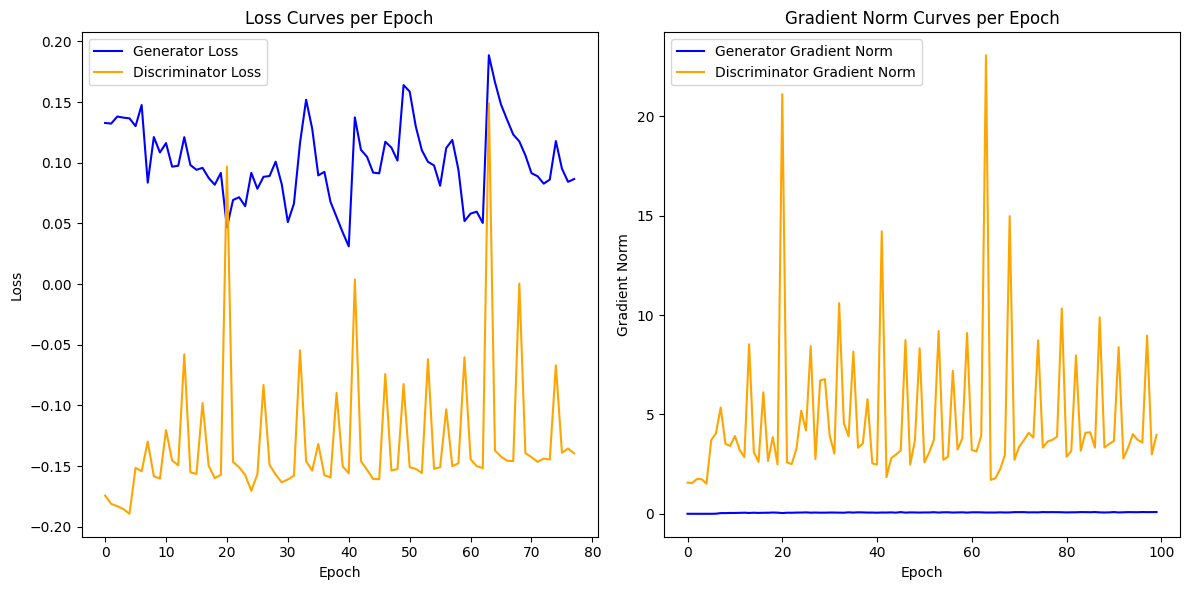

In [ ]:


# Plotting Loss Curves
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(G_l1, label="Generator Loss", color="blue")
plt.plot(D_l1, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves per Epoch")
plt.legend()

# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(G_grad_norms, label="Generator Gradient Norm", color="blue")
plt.plot(D_grad_norms, label="Discriminator Gradient Norm", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Curves per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### Image generation

In [ ]:
# Parameters
batch_size = 64  # Set your desired batch size
n_samples_target = 10000  # Total number of samples to generate

print('Model Loading...')
# Model Pipeline
mnist_dim = 784
model = Generator(g_output_dim=mnist_dim)
model = load_model(model, 'checkpoints',100)
model = torch.nn.DataParallel(model)
model.eval()

print('Model loaded.')
print('Start Generating')
os.makedirs('samples_new', exist_ok=True)

n_samples = 0
with torch.no_grad():
    while n_samples < n_samples_target:
        z = torch.randn(batch_size, 200)
        x = model(z)
        x = x.reshape(batch_size, 1, 28, 28)  # Reshape for saving
        for k in range(x.shape[0]):
            if n_samples < n_samples_target:
                torchvision.utils.save_image(x[k], os.path.join('samples_new', f'{n_samples}.png'))
                n_samples += 1

print('Generated samples done.')


Model Loading...
Model loaded.
Start Generating


<ipython-input-23-3fc1c724e5f7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))


Generated samples done.


### Calculating FID


In [ ]:
pip install pytorch-fid

In [ ]:
from torchvision.utils import save_image
path_real = 'samples_real'
os.makedirs(path_real, exist_ok=True)

# Save a subset of real images to the directory
n_samples = 10000  # Set the number of real samples you want to save
for i in range(n_samples):
    image, _ = train_dataset[i]  # Get the i-th image
    save_image(image, os.path.join(path_real, f'real_sample_{i}.png'), normalize=True)

print(f"Saved {n_samples} real MNIST images to '{path_real}'.")

Saved 10000 real MNIST images to 'samples_real'.


In [ ]:
from pytorch_fid import fid_score

# Calculate FID between two directories

path_fake = "samples_new"
fid_value = fid_score.calculate_fid_given_paths([path_real, path_fake], batch_size=64, device='cuda', dims=2048)

print(f"FID Score: {fid_value}")


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


FID Score: 147.10678668006395


## σ = 0.5

In [ ]:
sigma=0.5
sigma1 = sigma*(torch.ones(K, d)).to(DEVICE)

### Training

In [ ]:
from tqdm import tqdm
folder="checkpoints"
if not os.path.exists(folder):
        os.makedirs(folder)

G_l1 = []
D_l1 = []
G_grad_norms = []
D_grad_norms = []

# Loop over the number of epochs
for epoch in range(1, epochs+1):
    G_loss_total = 0.0
    D_loss_total = 0.0
    D1=0.0
    G1=0.0

    # Loop over the training dataset
    for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
        x = x.view(-1, 784).to(DEVICE)  # Flatten the images (for MNIST)
        y = y.to(DEVICE)

        # Train the Discriminator
        D_loss = D_train(x, y, G, D, D_optimizer, mu, sigma1)
        D_loss_total += D_loss
        # Capture gradients for Discriminator
        D_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in D.parameters() if param.grad is not None]))
        D1+=D_grad_norm


        # Train the Generator
        G_loss = G_train(x, y, G, D, G_optimizer, mu, sigma1)
        G_loss_total += G_loss
        # Capture gradients for Generator
        G_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in G.parameters() if param.grad is not None]))
        G1+=G_grad_norm

    # Average losses for the epoch
    D_loss_avg = D_loss_total / len(train_loader)
    G_loss_avg = G_loss_total / len(train_loader)
    G_grad_avg = G1/len(train_loader)
    D_grad_avg = D1/len(train_loader)
    D_l1.append(D_loss_avg)
    G_l1.append(G_loss_avg)
    G_grad_norms.append(G_grad_avg)
    D_grad_norms.append(D_grad_avg)


    # Logging the progress
    print(f"Epoch [{epoch}/{epochs}], D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}")

    # Save the model at specified intervals
    if epoch % log_interval == 0:
        save_models(G, D, f'epoch_{epoch}','checkpoints')
        print(f"Models saved at epoch {epoch}")

print("Training complete.")


Epoch 1/100: 100%|██████████| 938/938 [00:38<00:00, 24.22it/s]


Epoch [1/100], D Loss: -0.2275, G Loss: 0.1959


Epoch 2/100: 100%|██████████| 938/938 [00:38<00:00, 24.38it/s]


Epoch [2/100], D Loss: -0.2620, G Loss: 0.1918


Epoch 3/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [3/100], D Loss: -0.2643, G Loss: 0.1849


Epoch 4/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [4/100], D Loss: -0.2656, G Loss: 0.1808


Epoch 5/100: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s]


Epoch [5/100], D Loss: -0.1763, G Loss: 0.1371


Epoch 6/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [6/100], D Loss: -0.1433, G Loss: 0.1038


Epoch 7/100: 100%|██████████| 938/938 [00:38<00:00, 24.27it/s]


Epoch [7/100], D Loss: -0.1614, G Loss: 0.1048


Epoch 8/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [8/100], D Loss: -0.1446, G Loss: 0.0936


Epoch 9/100: 100%|██████████| 938/938 [00:39<00:00, 23.78it/s]


Epoch [9/100], D Loss: -0.1421, G Loss: 0.0801


Epoch 10/100: 100%|██████████| 938/938 [00:38<00:00, 24.14it/s]


Epoch [10/100], D Loss: -0.1415, G Loss: 0.0832
Models saved to checkpoints
Models saved at epoch 10


Epoch 11/100: 100%|██████████| 938/938 [00:39<00:00, 24.03it/s]


Epoch [11/100], D Loss: -0.1118, G Loss: 0.0643


Epoch 12/100: 100%|██████████| 938/938 [00:39<00:00, 23.87it/s]


Epoch [12/100], D Loss: -0.1332, G Loss: 0.0698


Epoch 13/100: 100%|██████████| 938/938 [00:39<00:00, 23.93it/s]


Epoch [13/100], D Loss: -0.0883, G Loss: 0.0843


Epoch 14/100: 100%|██████████| 938/938 [00:39<00:00, 23.65it/s]


Epoch [14/100], D Loss: -0.1185, G Loss: 0.0818


Epoch 15/100: 100%|██████████| 938/938 [00:39<00:00, 23.80it/s]


Epoch [15/100], D Loss: 0.0515, G Loss: 0.0541


Epoch 16/100: 100%|██████████| 938/938 [00:39<00:00, 24.00it/s]


Epoch [16/100], D Loss: -0.0993, G Loss: 0.0587


Epoch 17/100: 100%|██████████| 938/938 [00:39<00:00, 23.46it/s]


Epoch [17/100], D Loss: -0.1013, G Loss: 0.0638


Epoch 18/100: 100%|██████████| 938/938 [00:39<00:00, 23.56it/s]


Epoch [18/100], D Loss: -0.1007, G Loss: 0.0621


Epoch 19/100: 100%|██████████| 938/938 [00:39<00:00, 23.81it/s]


Epoch [19/100], D Loss: -0.0898, G Loss: 0.0606


Epoch 20/100: 100%|██████████| 938/938 [00:38<00:00, 24.17it/s]


Epoch [20/100], D Loss: -0.0886, G Loss: 0.0587
Models saved to checkpoints
Models saved at epoch 20


Epoch 21/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [21/100], D Loss: -0.0853, G Loss: 0.0573


Epoch 22/100: 100%|██████████| 938/938 [00:39<00:00, 23.97it/s]


Epoch [22/100], D Loss: 0.2580, G Loss: -0.0307


Epoch 23/100: 100%|██████████| 938/938 [00:39<00:00, 23.83it/s]


Epoch [23/100], D Loss: -0.0727, G Loss: -0.0205


Epoch 24/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [24/100], D Loss: -0.0765, G Loss: -0.0340


Epoch 25/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [25/100], D Loss: -0.0773, G Loss: -0.0204


Epoch 26/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [26/100], D Loss: -0.0789, G Loss: -0.0138


Epoch 27/100: 100%|██████████| 938/938 [00:38<00:00, 24.46it/s]


Epoch [27/100], D Loss: -0.0767, G Loss: -0.0036


Epoch 28/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [28/100], D Loss: -0.0663, G Loss: 0.0142


Epoch 29/100: 100%|██████████| 938/938 [00:38<00:00, 24.27it/s]


Epoch [29/100], D Loss: 0.3236, G Loss: 0.0399


Epoch 30/100: 100%|██████████| 938/938 [00:38<00:00, 24.38it/s]


Epoch [30/100], D Loss: -0.0587, G Loss: 0.0400
Models saved to checkpoints
Models saved at epoch 30


Epoch 31/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [31/100], D Loss: -0.0650, G Loss: 0.0409


Epoch 32/100: 100%|██████████| 938/938 [00:38<00:00, 24.53it/s]


Epoch [32/100], D Loss: -0.0673, G Loss: 0.0388


Epoch 33/100: 100%|██████████| 938/938 [00:38<00:00, 24.32it/s]


Epoch [33/100], D Loss: -0.0658, G Loss: 0.0342


Epoch 34/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [34/100], D Loss: -0.0636, G Loss: 0.0374


Epoch 35/100: 100%|██████████| 938/938 [00:38<00:00, 24.62it/s]


Epoch [35/100], D Loss: -0.0600, G Loss: 0.0591


Epoch 36/100: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]


Epoch [36/100], D Loss: 0.0956, G Loss: 0.0349


Epoch 37/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [37/100], D Loss: -0.0514, G Loss: 0.0259


Epoch 38/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [38/100], D Loss: -0.0572, G Loss: 0.0295


Epoch 39/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [39/100], D Loss: -0.0554, G Loss: 0.0306


Epoch 40/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [40/100], D Loss: -0.0518, G Loss: 0.0337
Models saved to checkpoints
Models saved at epoch 40


Epoch 41/100: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Epoch [41/100], D Loss: 0.0380, G Loss: 0.0270


Epoch 42/100: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Epoch [42/100], D Loss: -0.0459, G Loss: 0.0311


Epoch 43/100: 100%|██████████| 938/938 [00:38<00:00, 24.68it/s]


Epoch [43/100], D Loss: -0.0469, G Loss: 0.0353


Epoch 44/100: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


Epoch [44/100], D Loss: -0.0457, G Loss: 0.0357


Epoch 45/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [45/100], D Loss: 0.0294, G Loss: 0.0518


Epoch 46/100: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]


Epoch [46/100], D Loss: -0.0450, G Loss: 0.0556


Epoch 47/100: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]


Epoch [47/100], D Loss: -0.0480, G Loss: 0.0554


Epoch 48/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [48/100], D Loss: -0.0468, G Loss: 0.0490


Epoch 49/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [49/100], D Loss: 0.2531, G Loss: 0.0385


Epoch 50/100: 100%|██████████| 938/938 [00:38<00:00, 24.08it/s]


Epoch [50/100], D Loss: -0.0382, G Loss: 0.0427
Models saved to checkpoints
Models saved at epoch 50


Epoch 51/100: 100%|██████████| 938/938 [00:38<00:00, 24.16it/s]


Epoch [51/100], D Loss: -0.0457, G Loss: 0.0557


Epoch 52/100: 100%|██████████| 938/938 [00:38<00:00, 24.57it/s]


Epoch [52/100], D Loss: -0.0456, G Loss: 0.0617


Epoch 53/100: 100%|██████████| 938/938 [00:38<00:00, 24.58it/s]


Epoch [53/100], D Loss: -0.0455, G Loss: 0.0638


Epoch 54/100: 100%|██████████| 938/938 [00:38<00:00, 24.56it/s]


Epoch [54/100], D Loss: -0.0465, G Loss: 0.0628


Epoch 55/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [55/100], D Loss: 0.0551, G Loss: 0.0180


Epoch 56/100: 100%|██████████| 938/938 [00:38<00:00, 24.41it/s]


Epoch [56/100], D Loss: -0.0408, G Loss: 0.0266


Epoch 57/100: 100%|██████████| 938/938 [00:38<00:00, 24.22it/s]


Epoch [57/100], D Loss: -0.0395, G Loss: 0.0339


Epoch 58/100: 100%|██████████| 938/938 [00:39<00:00, 23.75it/s]


Epoch [58/100], D Loss: -0.0430, G Loss: 0.0335


Epoch 59/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [59/100], D Loss: -0.0380, G Loss: 0.0631


Epoch 60/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [60/100], D Loss: 0.3169, G Loss: 0.0381
Models saved to checkpoints
Models saved at epoch 60


Epoch 61/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [61/100], D Loss: -0.0338, G Loss: 0.0518


Epoch 62/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [62/100], D Loss: -0.0392, G Loss: 0.0400


Epoch 63/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]


Epoch [63/100], D Loss: -0.0413, G Loss: 0.0332


Epoch 64/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [64/100], D Loss: -0.0415, G Loss: 0.0366


Epoch 65/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [65/100], D Loss: -0.0431, G Loss: 0.0359


Epoch 66/100: 100%|██████████| 938/938 [00:38<00:00, 24.32it/s]


Epoch [66/100], D Loss: -0.0396, G Loss: 0.0358


Epoch 67/100: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Epoch [67/100], D Loss: 0.1646, G Loss: 0.0347


Epoch 68/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [68/100], D Loss: -0.0346, G Loss: 0.0097


Epoch 69/100: 100%|██████████| 938/938 [00:38<00:00, 24.46it/s]


Epoch [69/100], D Loss: -0.0376, G Loss: 0.0066


Epoch 70/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [70/100], D Loss: -0.0409, G Loss: 0.0197
Models saved to checkpoints
Models saved at epoch 70


Epoch 71/100: 100%|██████████| 938/938 [00:38<00:00, 24.19it/s]


Epoch [71/100], D Loss: -0.0396, G Loss: 0.0311


Epoch 72/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [72/100], D Loss: 0.0149, G Loss: 0.0583


Epoch 73/100: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch [73/100], D Loss: -0.0371, G Loss: 0.0265


Epoch 74/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [74/100], D Loss: -0.0359, G Loss: 0.0229


Epoch 75/100: 100%|██████████| 938/938 [00:41<00:00, 22.50it/s]


Epoch [75/100], D Loss: 0.0344, G Loss: 0.0484


Epoch 76/100: 100%|██████████| 938/938 [00:44<00:00, 20.89it/s]


Epoch [76/100], D Loss: -0.0319, G Loss: 0.0429


Epoch 77/100: 100%|██████████| 938/938 [00:40<00:00, 23.10it/s]


Epoch [77/100], D Loss: -0.0311, G Loss: 0.0263


Epoch 78/100: 100%|██████████| 938/938 [00:41<00:00, 22.59it/s]


Epoch [78/100], D Loss: 0.0281, G Loss: 0.0317


Epoch 79/100: 100%|██████████| 938/938 [00:40<00:00, 23.04it/s]


Epoch [79/100], D Loss: -0.0268, G Loss: 0.0522


Epoch 80/100: 100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Epoch [80/100], D Loss: -0.0336, G Loss: 0.0397
Models saved to checkpoints
Models saved at epoch 80


Epoch 81/100: 100%|██████████| 938/938 [00:42<00:00, 21.95it/s]


Epoch [81/100], D Loss: 0.1062, G Loss: 0.0522


Epoch 82/100: 100%|██████████| 938/938 [00:40<00:00, 23.37it/s]


Epoch [82/100], D Loss: -0.0295, G Loss: 0.0212


Epoch 83/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [83/100], D Loss: -0.0357, G Loss: 0.0252


Epoch 84/100: 100%|██████████| 938/938 [00:38<00:00, 24.32it/s]


Epoch [84/100], D Loss: -0.0356, G Loss: 0.0277


Epoch 85/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [85/100], D Loss: 0.0136, G Loss: 0.0347


Epoch 86/100: 100%|██████████| 938/938 [00:39<00:00, 23.67it/s]


Epoch [86/100], D Loss: -0.0278, G Loss: 0.0201


Epoch 87/100: 100%|██████████| 938/938 [00:38<00:00, 24.08it/s]


Epoch [87/100], D Loss: -0.0348, G Loss: 0.0198


Epoch 88/100: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s]


Epoch [88/100], D Loss: 0.0421, G Loss: -0.0069


Epoch 89/100: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Epoch [89/100], D Loss: -0.0322, G Loss: -0.0014


Epoch 90/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [90/100], D Loss: -0.0329, G Loss: 0.0131
Models saved to checkpoints
Models saved at epoch 90


Epoch 91/100: 100%|██████████| 938/938 [00:38<00:00, 24.19it/s]


Epoch [91/100], D Loss: -0.0338, G Loss: 0.0183


Epoch 92/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [92/100], D Loss: 0.0653, G Loss: 0.1268


Epoch 93/100: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Epoch [93/100], D Loss: -0.0285, G Loss: 0.0476


Epoch 94/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [94/100], D Loss: -0.0346, G Loss: 0.0381


Epoch 95/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [95/100], D Loss: -0.0277, G Loss: 0.0518


Epoch 96/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [96/100], D Loss: 0.0696, G Loss: 0.0655


Epoch 97/100: 100%|██████████| 938/938 [00:38<00:00, 24.08it/s]


Epoch [97/100], D Loss: -0.0279, G Loss: 0.0414


Epoch 98/100: 100%|██████████| 938/938 [00:38<00:00, 24.48it/s]


Epoch [98/100], D Loss: -0.0218, G Loss: 0.0240


Epoch 99/100: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Epoch [99/100], D Loss: -0.0310, G Loss: 0.0432


Epoch 100/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]

Epoch [100/100], D Loss: 0.8742, G Loss: -0.0407
Models saved to checkpoints
Models saved at epoch 100
Training complete.


### Downloading files

In [ ]:
from google.colab import files
!zip -r checkpoints.zip checkpoints/
files.download('checkpoints.zip')
import matplotlib.pyplot as plt

### Plotting loss and gradients

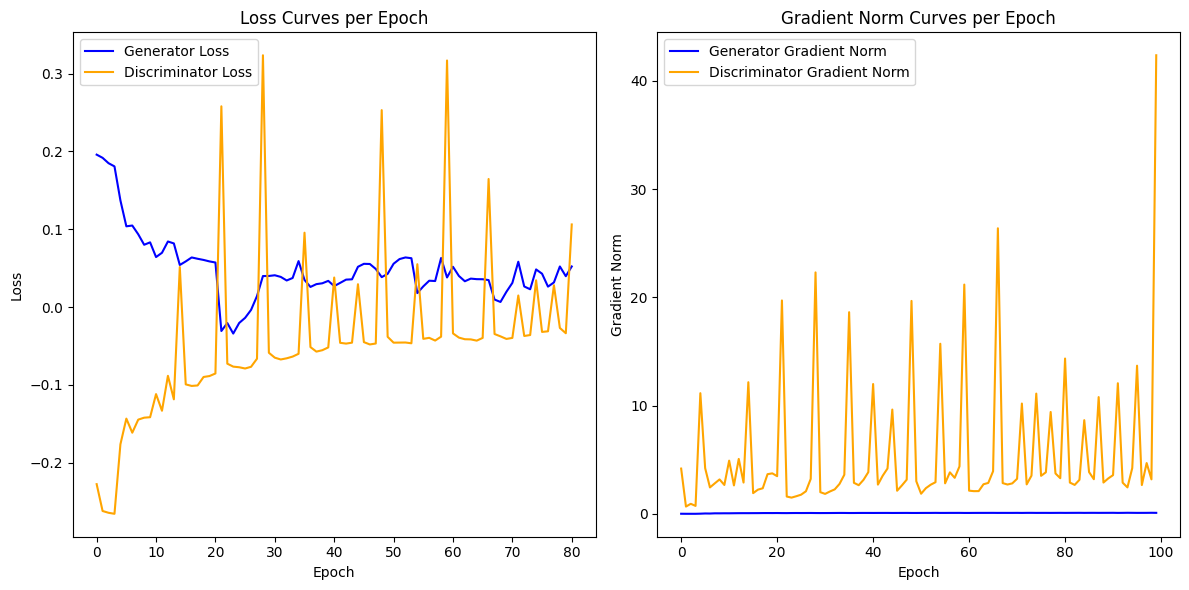

In [ ]:

G_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_grad_norms])
D_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_grad_norms])



# Plotting Loss Curves
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(G_l1, label="Generator Loss", color="blue")
plt.plot(D_l1, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves per Epoch")
plt.legend()

# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(G_grad_norms, label="Generator Gradient Norm", color="blue")
plt.plot(D_grad_norms, label="Discriminator Gradient Norm", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Curves per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### Image generation

In [ ]:
import torch
import torchvision
import os



# Parameters
batch_size = 64  # Set your desired batch size
n_samples_target = 10000  # Total number of samples to generate

print('Model Loading...')
# Model Pipeline
mnist_dim = 784
model = Generator(g_output_dim=mnist_dim)
model = load_model(model, 'checkpoints',100)
model = torch.nn.DataParallel(model)
model.eval()

print('Model loaded.')
print('Start Generating')
os.makedirs('samples_new', exist_ok=True)

n_samples = 0
with torch.no_grad():
    while n_samples < n_samples_target:
        z = torch.randn(batch_size, 200)
        x = model(z)
        x = x.reshape(batch_size, 1, 28, 28)  # Reshape for saving
        for k in range(x.shape[0]):
            if n_samples < n_samples_target:
                torchvision.utils.save_image(x[k], os.path.join('samples_new', f'{n_samples}.png'))
                n_samples += 1

print('Generated samples done.')


Model Loading...
Model loaded.
Start Generating


<ipython-input-4-3fc1c724e5f7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))


Generated samples done.


In [ ]:
pip install pytorch-fid

In [ ]:
from google.colab import files
!zip -r samples_new.zip samples_new/
files.download('samples_new.zip')

### Calculating FID

In [ ]:
path_real = 'samples_real'
os.makedirs(path_real, exist_ok=True)

# Save a subset of real images to the directory
n_samples = 10000  # Set the number of real samples you want to save
for i in range(n_samples):
    image, _ = train_dataset[i]  # Get the i-th image
    save_image(image, os.path.join(path_real, f'real_sample_{i}.png'), normalize=True)

print(f"Saved {n_samples} real MNIST images to '{path_real}'.")

from pytorch_fid import fid_score

# Calculate FID between two directories

path_fake = "samples_new"
fid_value = fid_score.calculate_fid_given_paths([path_real, path_fake], batch_size=64, device='cuda', dims=2048)

print(f"FID Score: {fid_value}")


Saved 10000 real MNIST images to 'samples_real'.


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 346MB/s]
100%|██████████| 157/157 [00:38<00:00,  4.13it/s]


FID Score: 145.40681569759755


## σ=1

In [ ]:
sigma=1.0
sigma1 = sigma*(torch.ones(K, d)).to(DEVICE)

### Training

In [ ]:
from tqdm import tqdm
folder="checkpoints"
if not os.path.exists(folder):
        os.makedirs(folder)

G_l1 = []
D_l1 = []
G_grad_norms = []
D_grad_norms = []

# Loop over the number of epochs
for epoch in range(1, epochs+1):
    G_loss_total = 0.0
    D_loss_total = 0.0
    D1=0.0
    G1=0.0

    # Loop over the training dataset
    for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
        x = x.view(-1, 784).to(DEVICE)  # Flatten the images (for MNIST)
        y = y.to(DEVICE)

        # Train the Discriminator
        D_loss = D_train(x, y, G, D, D_optimizer, mu, sigma1)
        D_loss_total += D_loss
        # Capture gradients for Discriminator
        D_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in D.parameters() if param.grad is not None]))
        D1+=D_grad_norm


        # Train the Generator
        G_loss = G_train(x, y, G, D, G_optimizer, mu, sigma1)
        G_loss_total += G_loss
        # Capture gradients for Generator
        G_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in G.parameters() if param.grad is not None]))
        G1+=G_grad_norm


    # Average losses for the epoch
    D_loss_avg = D_loss_total / len(train_loader)
    G_loss_avg = G_loss_total / len(train_loader)
    G_grad_avg = G1/len(train_loader)
    D_grad_avg = D1/len(train_loader)
    D_l1.append(D_loss_avg)
    G_l1.append(G_loss_avg)
    G_grad_norms.append(G_grad_avg)
    D_grad_norms.append(D_grad_avg)


    # Logging the progress
    print(f"Epoch [{epoch}/{epochs}], D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}")

    # Save the model at specified intervals
    if epoch % log_interval == 0:
        save_models(G, D, f'epoch_{epoch}','checkpoints')
        print(f"Models saved at epoch {epoch}")

print("Training complete.")


Epoch 1/100: 100%|██████████| 938/938 [00:45<00:00, 20.76it/s]


Epoch [1/100], D Loss: -0.1453, G Loss: 0.1638


Epoch 2/100: 100%|██████████| 938/938 [00:42<00:00, 22.13it/s]


Epoch [2/100], D Loss: -0.1266, G Loss: 0.1329


Epoch 3/100: 100%|██████████| 938/938 [00:43<00:00, 21.32it/s]


Epoch [3/100], D Loss: -0.1088, G Loss: 0.1037


Epoch 4/100: 100%|██████████| 938/938 [00:39<00:00, 23.56it/s]


Epoch [4/100], D Loss: -0.0751, G Loss: 0.0957


Epoch 5/100: 100%|██████████| 938/938 [00:41<00:00, 22.72it/s]


Epoch [5/100], D Loss: -0.0819, G Loss: 0.0982


Epoch 6/100: 100%|██████████| 938/938 [00:44<00:00, 21.16it/s]


Epoch [6/100], D Loss: -0.0685, G Loss: 0.0957


Epoch 7/100: 100%|██████████| 938/938 [00:41<00:00, 22.47it/s]


Epoch [7/100], D Loss: -0.0086, G Loss: 0.0680


Epoch 8/100: 100%|██████████| 938/938 [00:43<00:00, 21.62it/s]


Epoch [8/100], D Loss: -0.0617, G Loss: 0.0984


Epoch 9/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [9/100], D Loss: -0.0518, G Loss: 0.0766


Epoch 10/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [10/100], D Loss: -0.0583, G Loss: 0.0703
Models saved to checkpoints
Models saved at epoch 10


Epoch 11/100: 100%|██████████| 938/938 [00:38<00:00, 24.05it/s]


Epoch [11/100], D Loss: -0.0601, G Loss: 0.0785


Epoch 12/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [12/100], D Loss: -0.0344, G Loss: 0.0693


Epoch 13/100: 100%|██████████| 938/938 [00:39<00:00, 24.02it/s]


Epoch [13/100], D Loss: 0.0493, G Loss: 0.0301


Epoch 14/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [14/100], D Loss: -0.0054, G Loss: 0.0553


Epoch 15/100: 100%|██████████| 938/938 [00:39<00:00, 24.01it/s]


Epoch [15/100], D Loss: -0.0439, G Loss: 0.0646


Epoch 16/100: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Epoch [16/100], D Loss: -0.0413, G Loss: 0.0713


Epoch 17/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [17/100], D Loss: -0.0186, G Loss: 0.0534


Epoch 18/100: 100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


Epoch [18/100], D Loss: -0.0281, G Loss: 0.0732


Epoch 19/100: 100%|██████████| 938/938 [00:38<00:00, 24.58it/s]


Epoch [19/100], D Loss: -0.0313, G Loss: 0.0689


Epoch 20/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [20/100], D Loss: -0.0287, G Loss: 0.0803
Models saved to checkpoints
Models saved at epoch 20


Epoch 21/100: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]


Epoch [21/100], D Loss: -0.0317, G Loss: 0.0791


Epoch 22/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [22/100], D Loss: 0.0595, G Loss: 0.1164


Epoch 23/100: 100%|██████████| 938/938 [00:39<00:00, 24.01it/s]


Epoch [23/100], D Loss: -0.0287, G Loss: 0.0822


Epoch 24/100: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Epoch [24/100], D Loss: -0.0318, G Loss: 0.0828


Epoch 25/100: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch [25/100], D Loss: 0.0752, G Loss: 0.0607


Epoch 26/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [26/100], D Loss: -0.0324, G Loss: 0.0719


Epoch 27/100: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch [27/100], D Loss: -0.0268, G Loss: 0.0541


Epoch 28/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [28/100], D Loss: -0.0287, G Loss: 0.0746


Epoch 29/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [29/100], D Loss: -0.0255, G Loss: 0.0851


Epoch 30/100: 100%|██████████| 938/938 [00:39<00:00, 23.98it/s]


Epoch [30/100], D Loss: 0.1010, G Loss: 0.0551
Models saved to checkpoints
Models saved at epoch 30


Epoch 31/100: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Epoch [31/100], D Loss: -0.0302, G Loss: 0.0601


Epoch 32/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [32/100], D Loss: -0.0289, G Loss: 0.0634


Epoch 33/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [33/100], D Loss: -0.0287, G Loss: 0.0680


Epoch 34/100: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Epoch [34/100], D Loss: -0.0296, G Loss: 0.0771


Epoch 35/100: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


Epoch [35/100], D Loss: 0.0369, G Loss: 0.1203


Epoch 36/100: 100%|██████████| 938/938 [00:38<00:00, 24.53it/s]


Epoch [36/100], D Loss: -0.0294, G Loss: 0.1124


Epoch 37/100: 100%|██████████| 938/938 [00:38<00:00, 24.07it/s]


Epoch [37/100], D Loss: -0.0297, G Loss: 0.1043


Epoch 38/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [38/100], D Loss: -0.0279, G Loss: 0.1129


Epoch 39/100: 100%|██████████| 938/938 [00:38<00:00, 24.38it/s]


Epoch [39/100], D Loss: -0.0258, G Loss: 0.1197


Epoch 40/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [40/100], D Loss: 0.1946, G Loss: 0.1256
Models saved to checkpoints
Models saved at epoch 40


Epoch 41/100: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s]


Epoch [41/100], D Loss: -0.0240, G Loss: 0.1124


Epoch 42/100: 100%|██████████| 938/938 [00:38<00:00, 24.26it/s]


Epoch [42/100], D Loss: -0.0181, G Loss: 0.0939


Epoch 43/100: 100%|██████████| 938/938 [00:40<00:00, 23.06it/s]


Epoch [43/100], D Loss: -0.0281, G Loss: 0.0874


Epoch 44/100: 100%|██████████| 938/938 [00:39<00:00, 23.86it/s]


Epoch [44/100], D Loss: 0.1411, G Loss: 0.0956


Epoch 45/100: 100%|██████████| 938/938 [00:39<00:00, 23.47it/s]


Epoch [45/100], D Loss: -0.0226, G Loss: 0.1962


Epoch 46/100: 100%|██████████| 938/938 [00:39<00:00, 23.86it/s]


Epoch [46/100], D Loss: -0.0133, G Loss: 0.2308


Epoch 47/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [47/100], D Loss: -0.0074, G Loss: 0.1137


Epoch 48/100: 100%|██████████| 938/938 [00:38<00:00, 24.19it/s]


Epoch [48/100], D Loss: -0.0236, G Loss: 0.1164


Epoch 49/100: 100%|██████████| 938/938 [00:39<00:00, 23.90it/s]


Epoch [49/100], D Loss: 0.0222, G Loss: 0.1875


Epoch 50/100: 100%|██████████| 938/938 [00:38<00:00, 24.08it/s]


Epoch [50/100], D Loss: 0.0102, G Loss: 0.2022
Models saved to checkpoints
Models saved at epoch 50


Epoch 51/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [51/100], D Loss: -0.0234, G Loss: 0.2182


Epoch 52/100: 100%|██████████| 938/938 [00:39<00:00, 23.81it/s]


Epoch [52/100], D Loss: 0.0095, G Loss: 0.2564


Epoch 53/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [53/100], D Loss: -0.0210, G Loss: 0.0892


Epoch 54/100: 100%|██████████| 938/938 [00:38<00:00, 24.26it/s]


Epoch [54/100], D Loss: -0.0085, G Loss: 0.0476


Epoch 55/100: 100%|██████████| 938/938 [00:39<00:00, 23.96it/s]


Epoch [55/100], D Loss: -0.0211, G Loss: 0.1289


Epoch 56/100: 100%|██████████| 938/938 [00:39<00:00, 23.94it/s]


Epoch [56/100], D Loss: -0.0085, G Loss: 0.1507


Epoch 57/100: 100%|██████████| 938/938 [00:40<00:00, 23.44it/s]


Epoch [57/100], D Loss: 0.0008, G Loss: 0.1778


Epoch 58/100: 100%|██████████| 938/938 [00:39<00:00, 23.49it/s]


Epoch [58/100], D Loss: -0.0110, G Loss: 0.1375


Epoch 59/100: 100%|██████████| 938/938 [00:40<00:00, 23.23it/s]


Epoch [59/100], D Loss: -0.0007, G Loss: 0.2291


Epoch 60/100: 100%|██████████| 938/938 [00:39<00:00, 23.76it/s]


Epoch [60/100], D Loss: -0.0236, G Loss: 0.1445
Models saved to checkpoints
Models saved at epoch 60


Epoch 61/100: 100%|██████████| 938/938 [00:39<00:00, 23.65it/s]


Epoch [61/100], D Loss: 0.0035, G Loss: 0.2007


Epoch 62/100: 100%|██████████| 938/938 [00:40<00:00, 23.42it/s]


Epoch [62/100], D Loss: -0.0168, G Loss: 0.1999


Epoch 63/100: 100%|██████████| 938/938 [00:39<00:00, 23.80it/s]


Epoch [63/100], D Loss: -0.0193, G Loss: 0.1611


Epoch 64/100: 100%|██████████| 938/938 [00:39<00:00, 23.52it/s]


Epoch [64/100], D Loss: -0.0227, G Loss: 0.1167


Epoch 65/100: 100%|██████████| 938/938 [00:40<00:00, 23.30it/s]


Epoch [65/100], D Loss: -0.0119, G Loss: 0.1068


Epoch 66/100: 100%|██████████| 938/938 [00:40<00:00, 22.95it/s]


Epoch [66/100], D Loss: -0.0215, G Loss: 0.1357


Epoch 67/100: 100%|██████████| 938/938 [00:39<00:00, 23.57it/s]


Epoch [67/100], D Loss: 0.0241, G Loss: 0.1923


Epoch 68/100: 100%|██████████| 938/938 [00:39<00:00, 23.59it/s]


Epoch [68/100], D Loss: -0.0018, G Loss: 0.0966


Epoch 69/100: 100%|██████████| 938/938 [00:39<00:00, 23.55it/s]


Epoch [69/100], D Loss: -0.0274, G Loss: 0.1151


Epoch 70/100: 100%|██████████| 938/938 [00:40<00:00, 23.43it/s]


Epoch [70/100], D Loss: -0.0234, G Loss: 0.1353
Models saved to checkpoints
Models saved at epoch 70


Epoch 71/100: 100%|██████████| 938/938 [00:39<00:00, 23.63it/s]


Epoch [71/100], D Loss: -0.0231, G Loss: 0.1030


Epoch 72/100: 100%|██████████| 938/938 [00:40<00:00, 23.30it/s]


Epoch [72/100], D Loss: 0.0351, G Loss: 0.1773


Epoch 73/100: 100%|██████████| 938/938 [00:39<00:00, 23.73it/s]


Epoch [73/100], D Loss: -0.0249, G Loss: 0.1360


Epoch 74/100: 100%|██████████| 938/938 [00:39<00:00, 23.54it/s]


Epoch [74/100], D Loss: -0.0239, G Loss: 0.1275


Epoch 75/100: 100%|██████████| 938/938 [00:39<00:00, 23.67it/s]


Epoch [75/100], D Loss: 0.1439, G Loss: 0.2070


Epoch 76/100: 100%|██████████| 938/938 [00:39<00:00, 23.77it/s]


Epoch [76/100], D Loss: -0.0287, G Loss: 0.2268


Epoch 77/100: 100%|██████████| 938/938 [00:39<00:00, 23.69it/s]


Epoch [77/100], D Loss: -0.0289, G Loss: 0.1983


Epoch 78/100: 100%|██████████| 938/938 [00:39<00:00, 23.79it/s]


Epoch [78/100], D Loss: -0.0218, G Loss: 0.1981


Epoch 79/100: 100%|██████████| 938/938 [00:40<00:00, 23.09it/s]


Epoch [79/100], D Loss: -0.0283, G Loss: 0.1644


Epoch 80/100: 100%|██████████| 938/938 [00:39<00:00, 23.54it/s]


Epoch [80/100], D Loss: 0.0688, G Loss: 0.1147
Models saved to checkpoints
Models saved at epoch 80


Epoch 81/100: 100%|██████████| 938/938 [00:39<00:00, 23.66it/s]


Epoch [81/100], D Loss: -0.0289, G Loss: 0.1270


Epoch 82/100: 100%|██████████| 938/938 [00:40<00:00, 23.44it/s]


Epoch [82/100], D Loss: -0.0304, G Loss: 0.1237


Epoch 83/100: 100%|██████████| 938/938 [00:39<00:00, 23.63it/s]


Epoch [83/100], D Loss: -0.0185, G Loss: 0.1711


Epoch 84/100: 100%|██████████| 938/938 [00:39<00:00, 23.68it/s]


Epoch [84/100], D Loss: 0.0004, G Loss: 0.0995


Epoch 85/100: 100%|██████████| 938/938 [00:39<00:00, 23.54it/s]


Epoch [85/100], D Loss: -0.0228, G Loss: 0.1048


Epoch 86/100: 100%|██████████| 938/938 [00:40<00:00, 23.18it/s]


Epoch [86/100], D Loss: 0.0450, G Loss: 0.1372


Epoch 87/100: 100%|██████████| 938/938 [00:39<00:00, 23.73it/s]


Epoch [87/100], D Loss: -0.0269, G Loss: 0.1501


Epoch 88/100: 100%|██████████| 938/938 [00:39<00:00, 23.74it/s]


Epoch [88/100], D Loss: -0.0237, G Loss: 0.1579


Epoch 89/100: 100%|██████████| 938/938 [00:39<00:00, 23.56it/s]


Epoch [89/100], D Loss: -0.0117, G Loss: 0.2174


Epoch 90/100: 100%|██████████| 938/938 [00:39<00:00, 23.50it/s]


Epoch [90/100], D Loss: -0.0244, G Loss: 0.2014
Models saved to checkpoints
Models saved at epoch 90


Epoch 91/100: 100%|██████████| 938/938 [00:39<00:00, 23.52it/s]


Epoch [91/100], D Loss: -0.0265, G Loss: 0.1636


Epoch 92/100: 100%|██████████| 938/938 [00:39<00:00, 23.60it/s]


Epoch [92/100], D Loss: -0.0077, G Loss: 0.1586


Epoch 93/100: 100%|██████████| 938/938 [00:40<00:00, 23.11it/s]


Epoch [93/100], D Loss: -0.0210, G Loss: 0.1137


Epoch 94/100: 100%|██████████| 938/938 [00:39<00:00, 23.66it/s]


Epoch [94/100], D Loss: -0.0205, G Loss: 0.1322


Epoch 95/100: 100%|██████████| 938/938 [00:38<00:00, 24.17it/s]


Epoch [95/100], D Loss: -0.0006, G Loss: 0.0881


Epoch 96/100: 100%|██████████| 938/938 [00:38<00:00, 24.16it/s]


Epoch [96/100], D Loss: -0.0184, G Loss: 0.0768


Epoch 97/100: 100%|██████████| 938/938 [00:39<00:00, 23.84it/s]


Epoch [97/100], D Loss: -0.0236, G Loss: 0.0953


Epoch 98/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [98/100], D Loss: -0.0141, G Loss: 0.1289


Epoch 99/100: 100%|██████████| 938/938 [00:38<00:00, 24.20it/s]


Epoch [99/100], D Loss: 0.0041, G Loss: 0.0037


Epoch 100/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [100/100], D Loss: -0.0243, G Loss: 0.0804
Models saved to checkpoints
Models saved at epoch 100
Training complete.


### Downloading checkpoints

In [ ]:
from google.colab import files
!zip -r checkpoints.zip checkpoints/
files.download('checkpoints.zip')
import matplotlib.pyplot as plt

### Plotting losses and gradients

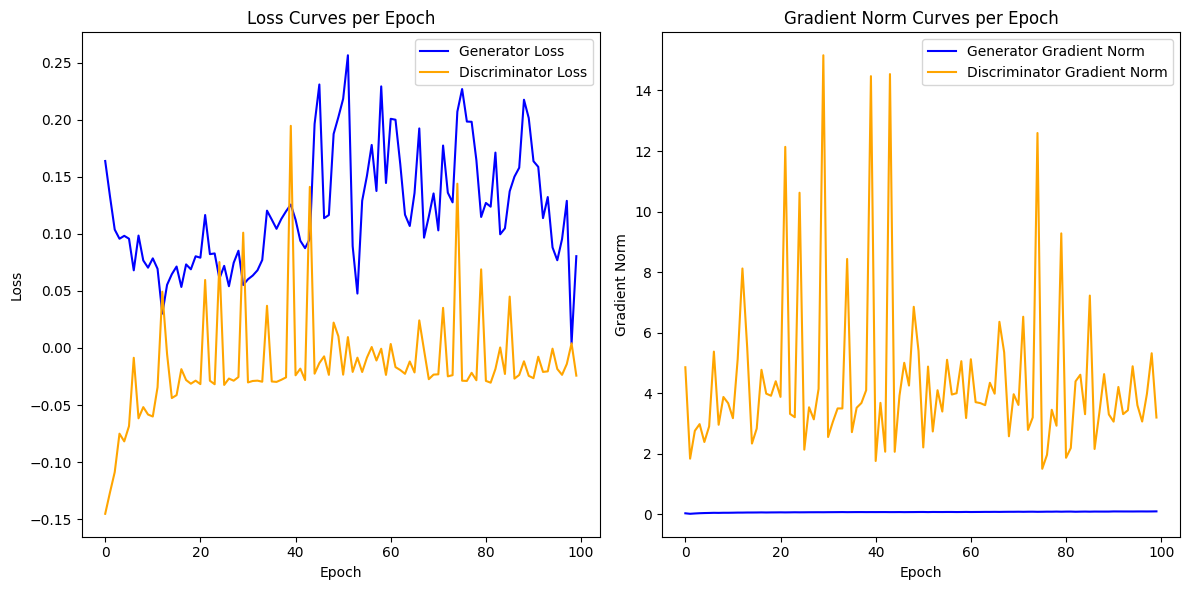

In [ ]:
G_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_grad_norms])
D_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_grad_norms])
D_l1 = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_l1])
G_l1 = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_l1])



# Plotting Loss Curves
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(G_l1, label="Generator Loss", color="blue")
plt.plot(D_l1, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves per Epoch")
plt.legend()

# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(G_grad_norms, label="Generator Gradient Norm", color="blue")
plt.plot(D_grad_norms, label="Discriminator Gradient Norm", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Curves per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### Image generation

In [ ]:
# Parameters
batch_size = 64  # Set your desired batch size
n_samples_target = 10000  # Total number of samples to generate

print('Model Loading...')
# Model Pipeline
mnist_dim = 784
model = Generator(g_output_dim=mnist_dim)
model = load_model(model, 'checkpoints',100)
model = torch.nn.DataParallel(model)
model.eval()

print('Model loaded.')
print('Start Generating')
os.makedirs('samples_new', exist_ok=True)

n_samples = 0
with torch.no_grad():
    while n_samples < n_samples_target:
        z = torch.randn(batch_size, 200)
        x = model(z)
        x = x.reshape(batch_size, 1, 28, 28)  # Reshape for saving
        for k in range(x.shape[0]):
            if n_samples < n_samples_target:
                torchvision.utils.save_image(x[k], os.path.join('samples_new', f'{n_samples}.png'))
                n_samples += 1

print('Generated samples done.')

from google.colab import files
!zip -r samples_new.zip samples_new/
files.download('samples_new.zip')


### Calculating FID

In [ ]:
pip install pytorch-fid

In [ ]:

from torchvision.utils import save_image
path_real = 'samples_real'
os.makedirs(path_real, exist_ok=True)

# Save a subset of real images to the directory
n_samples = 10000  # Set the number of real samples you want to save
for i in range(n_samples):
    image, _ = train_dataset[i]  # Get the i-th image
    save_image(image, os.path.join(path_real, f'real_sample_{i}.png'), normalize=True)

print(f"Saved {n_samples} real MNIST images to '{path_real}'.")

from pytorch_fid import fid_score

# Calculate FID between two directories

path_fake = "samples_new"
fid_value = fid_score.calculate_fid_given_paths([path_real, path_fake], batch_size=64, device='cuda', dims=2048)

print(f"FID Score: {fid_value}")


Saved 10000 real MNIST images to 'samples_real'.


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 93.9MB/s]
100%|██████████| 157/157 [00:38<00:00,  4.08it/s]


FID Score: 110.46911600131568


## σ = 1.5

In [ ]:
sigma=1.5
sigma1 = sigma*(torch.ones(K, d)).to(DEVICE)

### Training

In [ ]:
from tqdm import tqdm
folder="checkpoints"
if not os.path.exists(folder):
        os.makedirs(folder)

G_l1 = []
D_l1 = []
G_grad_norms = []
D_grad_norms = []

# Loop over the number of epochs
for epoch in range(1, epochs+1):
    G_loss_total = 0.0
    D_loss_total = 0.0
    D1=0.0
    G1=0.0

    # Loop over the training dataset
    for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
        x = x.view(-1, 784).to(DEVICE)  # Flatten the images (for MNIST)
        y = y.to(DEVICE)

        # Train the Discriminator
        D_loss = D_train(x, y, G, D, D_optimizer, mu, sigma1)
        D_loss_total += D_loss


        # Capture gradients for Discriminator
        D_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in D.parameters() if param.grad is not None]))
        D1+=D_grad_norm
        # Train the Generator
        G_loss = G_train(x, y, G, D, G_optimizer, mu, sigma1)
        G_loss_total += G_loss


        # Capture gradients for Generator
        G_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in G.parameters() if param.grad is not None]))
        G1+=G_grad_norm
    # Average losses for the epoch
    D_loss_avg = D_loss_total / len(train_loader)
    G_loss_avg = G_loss_total / len(train_loader)
    G_grad_avg = G1/len(train_loader)
    D_grad_avg = D1/len(train_loader)
    D_l1.append(D_loss_avg)
    G_l1.append(G_loss_avg)
    G_grad_norms.append(G_grad_avg)
    D_grad_norms.append(D_grad_avg)


    # Logging the progress
    print(f"Epoch [{epoch}/{epochs}], D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}")

    # Save the model at specified intervals
    if epoch % log_interval == 0:
        save_models(G, D, f'epoch_{epoch}','checkpoints')
        print(f"Models saved at epoch {epoch}")

print("Training complete.")


Epoch 1/100: 100%|██████████| 938/938 [00:42<00:00, 22.24it/s]


Epoch [1/100], D Loss: -0.3285, G Loss: 0.2378


Epoch 2/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [2/100], D Loss: -0.1531, G Loss: 0.1536


Epoch 3/100: 100%|██████████| 938/938 [00:39<00:00, 23.72it/s]


Epoch [3/100], D Loss: -0.1248, G Loss: 0.1270


Epoch 4/100: 100%|██████████| 938/938 [00:39<00:00, 24.02it/s]


Epoch [4/100], D Loss: -0.1088, G Loss: 0.1217


Epoch 5/100: 100%|██████████| 938/938 [00:39<00:00, 23.85it/s]


Epoch [5/100], D Loss: -0.0896, G Loss: 0.1110


Epoch 6/100: 100%|██████████| 938/938 [00:39<00:00, 23.48it/s]


Epoch [6/100], D Loss: -0.0821, G Loss: 0.1098


Epoch 7/100: 100%|██████████| 938/938 [00:39<00:00, 23.95it/s]


Epoch [7/100], D Loss: -0.0550, G Loss: 0.0839


Epoch 8/100: 100%|██████████| 938/938 [00:39<00:00, 23.90it/s]


Epoch [8/100], D Loss: -0.0429, G Loss: 0.0700


Epoch 9/100: 100%|██████████| 938/938 [00:39<00:00, 23.91it/s]


Epoch [9/100], D Loss: -0.0638, G Loss: 0.0853


Epoch 10/100: 100%|██████████| 938/938 [00:39<00:00, 23.87it/s]


Epoch [10/100], D Loss: -0.0330, G Loss: 0.0399
Models saved to checkpoints
Models saved at epoch 10


Epoch 11/100: 100%|██████████| 938/938 [00:40<00:00, 23.25it/s]


Epoch [11/100], D Loss: -0.0542, G Loss: 0.0645


Epoch 12/100: 100%|██████████| 938/938 [00:39<00:00, 23.55it/s]


Epoch [12/100], D Loss: -0.0483, G Loss: 0.0679


Epoch 13/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [13/100], D Loss: -0.0164, G Loss: 0.0600


Epoch 14/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [14/100], D Loss: -0.0384, G Loss: 0.0559


Epoch 15/100: 100%|██████████| 938/938 [00:39<00:00, 23.79it/s]


Epoch [15/100], D Loss: -0.0458, G Loss: 0.0672


Epoch 16/100: 100%|██████████| 938/938 [00:39<00:00, 24.00it/s]


Epoch [16/100], D Loss: -0.0238, G Loss: 0.0844


Epoch 17/100: 100%|██████████| 938/938 [00:38<00:00, 24.66it/s]


Epoch [17/100], D Loss: -0.0364, G Loss: 0.0581


Epoch 18/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [18/100], D Loss: -0.0013, G Loss: 0.0662


Epoch 19/100: 100%|██████████| 938/938 [00:38<00:00, 24.19it/s]


Epoch [19/100], D Loss: -0.0367, G Loss: 0.0633


Epoch 20/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [20/100], D Loss: -0.0368, G Loss: 0.0706
Models saved to checkpoints
Models saved at epoch 20


Epoch 21/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [21/100], D Loss: -0.0353, G Loss: 0.0710


Epoch 22/100: 100%|██████████| 938/938 [00:40<00:00, 23.37it/s]


Epoch [22/100], D Loss: -0.0244, G Loss: 0.0576


Epoch 23/100: 100%|██████████| 938/938 [00:38<00:00, 24.35it/s]


Epoch [23/100], D Loss: 0.0001, G Loss: 0.1149


Epoch 24/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [24/100], D Loss: -0.0342, G Loss: 0.1069


Epoch 25/100: 100%|██████████| 938/938 [00:38<00:00, 24.60it/s]


Epoch [25/100], D Loss: -0.0360, G Loss: 0.1080


Epoch 26/100: 100%|██████████| 938/938 [00:38<00:00, 24.35it/s]


Epoch [26/100], D Loss: 0.0167, G Loss: 0.1285


Epoch 27/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [27/100], D Loss: -0.0326, G Loss: 0.1157


Epoch 28/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [28/100], D Loss: -0.0342, G Loss: 0.1192


Epoch 29/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [29/100], D Loss: -0.0262, G Loss: 0.1108


Epoch 30/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [30/100], D Loss: 0.1226, G Loss: 0.0038
Models saved to checkpoints
Models saved at epoch 30


Epoch 31/100: 100%|██████████| 938/938 [00:38<00:00, 24.60it/s]


Epoch [31/100], D Loss: -0.0306, G Loss: 0.0195


Epoch 32/100: 100%|██████████| 938/938 [00:38<00:00, 24.62it/s]


Epoch [32/100], D Loss: -0.0332, G Loss: 0.0269


Epoch 33/100: 100%|██████████| 938/938 [00:38<00:00, 24.41it/s]


Epoch [33/100], D Loss: -0.0323, G Loss: 0.0429


Epoch 34/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [34/100], D Loss: -0.0320, G Loss: 0.0546


Epoch 35/100: 100%|██████████| 938/938 [00:39<00:00, 23.99it/s]


Epoch [35/100], D Loss: 0.0205, G Loss: 0.1464


Epoch 36/100: 100%|██████████| 938/938 [00:39<00:00, 23.85it/s]


Epoch [36/100], D Loss: -0.0292, G Loss: 0.1285


Epoch 37/100: 100%|██████████| 938/938 [00:39<00:00, 23.50it/s]


Epoch [37/100], D Loss: -0.0236, G Loss: 0.1176


Epoch 38/100: 100%|██████████| 938/938 [00:39<00:00, 23.88it/s]


Epoch [38/100], D Loss: -0.0307, G Loss: 0.1254


Epoch 39/100: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s]


Epoch [39/100], D Loss: 0.0301, G Loss: 0.1055


Epoch 40/100: 100%|██████████| 938/938 [00:39<00:00, 23.96it/s]


Epoch [40/100], D Loss: -0.0307, G Loss: 0.0928
Models saved to checkpoints
Models saved at epoch 40


Epoch 41/100: 100%|██████████| 938/938 [00:39<00:00, 23.97it/s]


Epoch [41/100], D Loss: -0.0303, G Loss: 0.1032


Epoch 42/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [42/100], D Loss: 0.1752, G Loss: 0.0361


Epoch 43/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [43/100], D Loss: -0.0025, G Loss: 0.1039


Epoch 44/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [44/100], D Loss: -0.0297, G Loss: 0.1070


Epoch 45/100: 100%|██████████| 938/938 [00:39<00:00, 23.70it/s]


Epoch [45/100], D Loss: -0.0318, G Loss: 0.1112


Epoch 46/100: 100%|██████████| 938/938 [00:40<00:00, 23.16it/s]


Epoch [46/100], D Loss: -0.0304, G Loss: 0.0982


Epoch 47/100: 100%|██████████| 938/938 [00:39<00:00, 23.51it/s]


Epoch [47/100], D Loss: -0.0263, G Loss: 0.1049


Epoch 48/100: 100%|██████████| 938/938 [00:40<00:00, 23.19it/s]


Epoch [48/100], D Loss: 0.0252, G Loss: 0.1802


Epoch 49/100: 100%|██████████| 938/938 [00:40<00:00, 23.38it/s]


Epoch [49/100], D Loss: -0.0269, G Loss: 0.1650


Epoch 50/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [50/100], D Loss: -0.0274, G Loss: 0.1495
Models saved to checkpoints
Models saved at epoch 50


Epoch 51/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [51/100], D Loss: 0.0357, G Loss: 0.1180


Epoch 52/100: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]


Epoch [52/100], D Loss: -0.0243, G Loss: 0.0991


Epoch 53/100: 100%|██████████| 938/938 [00:39<00:00, 23.90it/s]


Epoch [53/100], D Loss: -0.0272, G Loss: 0.1144


Epoch 54/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [54/100], D Loss: 0.0355, G Loss: 0.0572


Epoch 55/100: 100%|██████████| 938/938 [00:40<00:00, 23.38it/s]


Epoch [55/100], D Loss: -0.0252, G Loss: 0.0622


Epoch 56/100: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Epoch [56/100], D Loss: -0.0285, G Loss: 0.0712


Epoch 57/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [57/100], D Loss: -0.0214, G Loss: 0.1254


Epoch 58/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [58/100], D Loss: 0.0296, G Loss: 0.1607


Epoch 59/100: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]


Epoch [59/100], D Loss: -0.0219, G Loss: 0.1548


Epoch 60/100: 100%|██████████| 938/938 [00:39<00:00, 23.89it/s]


Epoch [60/100], D Loss: -0.0236, G Loss: 0.1189
Models saved to checkpoints
Models saved at epoch 60


Epoch 61/100: 100%|██████████| 938/938 [00:39<00:00, 23.58it/s]


Epoch [61/100], D Loss: 0.0066, G Loss: 0.1830


Epoch 62/100: 100%|██████████| 938/938 [00:39<00:00, 23.75it/s]


Epoch [62/100], D Loss: -0.0244, G Loss: 0.1321


Epoch 63/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [63/100], D Loss: -0.0256, G Loss: 0.1220


Epoch 64/100: 100%|██████████| 938/938 [00:38<00:00, 24.16it/s]


Epoch [64/100], D Loss: 0.0072, G Loss: 0.0960


Epoch 65/100: 100%|██████████| 938/938 [00:38<00:00, 24.67it/s]


Epoch [65/100], D Loss: -0.0107, G Loss: 0.1212


Epoch 66/100: 100%|██████████| 938/938 [00:38<00:00, 24.67it/s]


Epoch [66/100], D Loss: -0.0207, G Loss: 0.1070


Epoch 67/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [67/100], D Loss: -0.0151, G Loss: 0.1497


Epoch 68/100: 100%|██████████| 938/938 [00:38<00:00, 24.14it/s]


Epoch [68/100], D Loss: -0.0031, G Loss: 0.0996


Epoch 69/100: 100%|██████████| 938/938 [00:39<00:00, 23.64it/s]


Epoch [69/100], D Loss: -0.0084, G Loss: 0.1260


Epoch 70/100: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Epoch [70/100], D Loss: -0.0252, G Loss: 0.1241
Models saved to checkpoints
Models saved at epoch 70


Epoch 71/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [71/100], D Loss: -0.0189, G Loss: 0.0933


Epoch 72/100: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]


Epoch [72/100], D Loss: 0.0169, G Loss: 0.1074


Epoch 73/100: 100%|██████████| 938/938 [00:38<00:00, 24.06it/s]


Epoch [73/100], D Loss: -0.0283, G Loss: 0.1097


Epoch 74/100: 100%|██████████| 938/938 [00:39<00:00, 23.99it/s]


Epoch [74/100], D Loss: -0.0301, G Loss: 0.0987


Epoch 75/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [75/100], D Loss: 0.0373, G Loss: 0.1276


Epoch 76/100: 100%|██████████| 938/938 [00:39<00:00, 23.74it/s]


Epoch [76/100], D Loss: -0.0254, G Loss: 0.1604


Epoch 77/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [77/100], D Loss: 0.0211, G Loss: 0.1613


Epoch 78/100: 100%|██████████| 938/938 [00:38<00:00, 24.35it/s]


Epoch [78/100], D Loss: -0.0270, G Loss: 0.1383


Epoch 79/100: 100%|██████████| 938/938 [00:39<00:00, 24.02it/s]


Epoch [79/100], D Loss: -0.0273, G Loss: 0.1752


Epoch 80/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [80/100], D Loss: -0.0184, G Loss: 0.1220
Models saved to checkpoints
Models saved at epoch 80


Epoch 81/100: 100%|██████████| 938/938 [00:38<00:00, 24.68it/s]


Epoch [81/100], D Loss: 0.0042, G Loss: 0.1643


Epoch 82/100: 100%|██████████| 938/938 [00:37<00:00, 24.69it/s]


Epoch [82/100], D Loss: -0.0222, G Loss: 0.1332


Epoch 83/100: 100%|██████████| 938/938 [00:39<00:00, 23.97it/s]


Epoch [83/100], D Loss: 0.0179, G Loss: 0.1750


Epoch 84/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [84/100], D Loss: -0.0216, G Loss: 0.1802


Epoch 85/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [85/100], D Loss: -0.0246, G Loss: 0.1586


Epoch 86/100: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch [86/100], D Loss: -0.0296, G Loss: 0.1490


Epoch 87/100: 100%|██████████| 938/938 [00:38<00:00, 24.41it/s]


Epoch [87/100], D Loss: -0.0191, G Loss: 0.1353


Epoch 88/100: 100%|██████████| 938/938 [00:38<00:00, 24.68it/s]


Epoch [88/100], D Loss: -0.0305, G Loss: 0.1361


Epoch 89/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [89/100], D Loss: 0.1584, G Loss: 0.1626


Epoch 90/100: 100%|██████████| 938/938 [00:39<00:00, 23.66it/s]


Epoch [90/100], D Loss: -0.0295, G Loss: 0.1578
Models saved to checkpoints
Models saved at epoch 90


Epoch 91/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [91/100], D Loss: -0.0317, G Loss: 0.1384


Epoch 92/100: 100%|██████████| 938/938 [00:39<00:00, 23.48it/s]


Epoch [92/100], D Loss: -0.0330, G Loss: 0.1281


Epoch 93/100: 100%|██████████| 938/938 [00:39<00:00, 23.65it/s]


Epoch [93/100], D Loss: -0.0248, G Loss: 0.1644


Epoch 94/100: 100%|██████████| 938/938 [00:38<00:00, 24.06it/s]


Epoch [94/100], D Loss: -0.0267, G Loss: 0.1667


Epoch 95/100: 100%|██████████| 938/938 [00:39<00:00, 23.80it/s]


Epoch [95/100], D Loss: 0.1281, G Loss: 0.1875


Epoch 96/100: 100%|██████████| 938/938 [00:39<00:00, 23.74it/s]


Epoch [96/100], D Loss: -0.0297, G Loss: 0.2202


Epoch 97/100: 100%|██████████| 938/938 [00:40<00:00, 23.31it/s]


Epoch [97/100], D Loss: -0.0321, G Loss: 0.1979


Epoch 98/100: 100%|██████████| 938/938 [00:39<00:00, 23.90it/s]


Epoch [98/100], D Loss: -0.0327, G Loss: 0.1859


Epoch 99/100: 100%|██████████| 938/938 [00:39<00:00, 23.66it/s]


Epoch [99/100], D Loss: -0.0293, G Loss: 0.1690


Epoch 100/100: 100%|██████████| 938/938 [00:48<00:00, 19.29it/s]


Epoch [100/100], D Loss: -0.0228, G Loss: 0.1171
Models saved to checkpoints
Models saved at epoch 100
Training complete.


### Plotting Losses and gradients

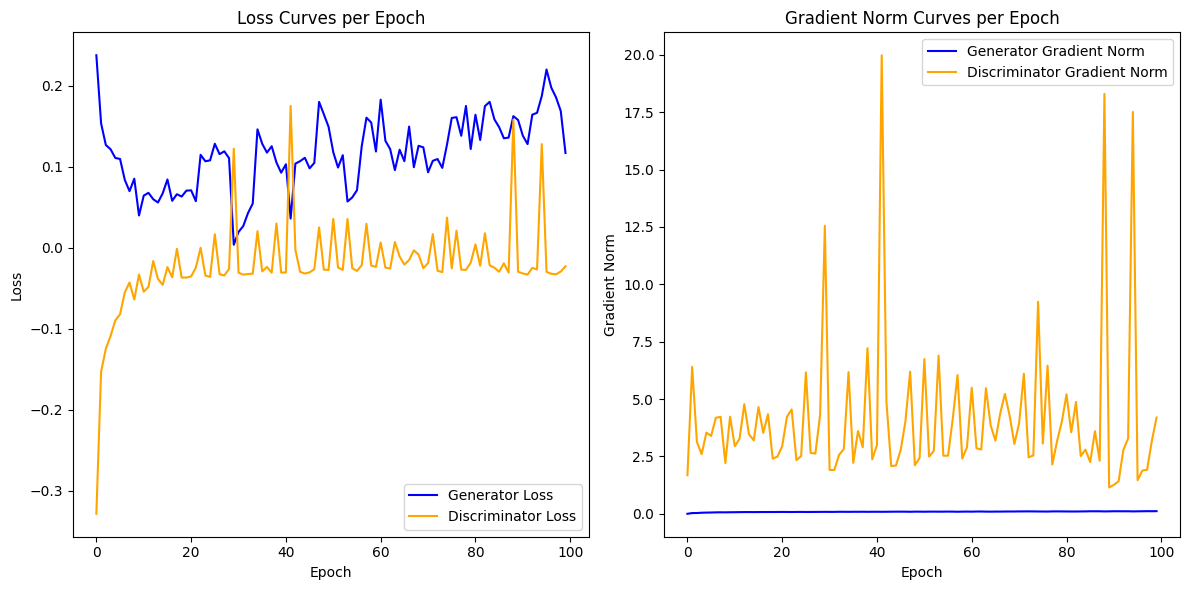

In [ ]:
import matplotlib.pyplot as plt
G_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_grad_norms])
D_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_grad_norms])
D_l1 = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_l1])
G_l1 = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_l1])



# Plotting Loss Curves
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(G_l1, label="Generator Loss", color="blue")
plt.plot(D_l1, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves per Epoch")
plt.legend()

# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(G_grad_norms, label="Generator Gradient Norm", color="blue")
plt.plot(D_grad_norms, label="Discriminator Gradient Norm", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Curves per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### Image Generation

In [ ]:
import torch
import torchvision
import os



# Parameters
batch_size = 64  # Set your desired batch size
n_samples_target = 10000  # Total number of samples to generate

print('Model Loading...')
# Model Pipeline
mnist_dim = 784
model = Generator(g_output_dim=mnist_dim)
model = load_model(model, 'checkpoints',100)
model = torch.nn.DataParallel(model)
model.eval()

print('Model loaded.')
print('Start Generating')
os.makedirs('samples_new', exist_ok=True)

n_samples = 0
with torch.no_grad():
    while n_samples < n_samples_target:
        z = torch.randn(batch_size, 200)
        x = model(z)
        x = x.reshape(batch_size, 1, 28, 28)  # Reshape for saving
        for k in range(x.shape[0]):
            if n_samples < n_samples_target:
                torchvision.utils.save_image(x[k], os.path.join('samples_new', f'{n_samples}.png'))
                n_samples += 1

print('Generated samples done.')


Model Loading...
Model loaded.
Start Generating


<ipython-input-9-3fc1c724e5f7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))


Generated samples done.


### Calculating FID

In [ ]:
from torchvision.utils import save_image
path_real = 'samples_real'
os.makedirs(path_real, exist_ok=True)

# Save a subset of real images to the directory
n_samples = 10000  # Set the number of real samples you want to save
for i in range(n_samples):
    image, _ = train_dataset[i]  # Get the i-th image
    save_image(image, os.path.join(path_real, f'real_sample_{i}.png'), normalize=True)

print(f"Saved {n_samples} real MNIST images to '{path_real}'.")

from pytorch_fid import fid_score

# Calculate FID between two directories

path_fake = "samples_new"
fid_value = fid_score.calculate_fid_given_paths([path_real, path_fake], batch_size=64, device='cuda', dims=2048)

print(f"FID Score: {fid_value}")


Saved 10000 real MNIST images to 'samples_real'.


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 254MB/s]
100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


FID Score: 117.71712589332415


## σ=2

In [ ]:
sigma=2.0
sigma1 = sigma*(torch.ones(K, d)).to(DEVICE)

### Training

In [ ]:
from tqdm import tqdm
folder="checkpoints"
if not os.path.exists(folder):
        os.makedirs(folder)

G_l1 = []
D_l1 = []
G_grad_norms = []
D_grad_norms = []

# Loop over the number of epochs
for epoch in range(1, epochs+1):
    G_loss_total = 0.0
    D_loss_total = 0.0
    D1=0.0
    G1=0.0

    # Loop over the training dataset
    for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
        x = x.view(-1, 784).to(DEVICE)  # Flatten the images (for MNIST)
        y = y.to(DEVICE)

        # Train the Discriminator
        D_loss = D_train(x, y, G, D, D_optimizer, mu, sigma1)
        D_loss_total += D_loss


        # Capture gradients for Discriminator
        D_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in D.parameters() if param.grad is not None]))
        D1+=D_grad_norm
        # Train the Generator
        G_loss = G_train(x, y, G, D, G_optimizer, mu, sigma1)
        G_loss_total += G_loss


        # Capture gradients for Generator
        G_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in G.parameters() if param.grad is not None]))
        G1+=G_grad_norm
    # Average losses for the epoch
    D_loss_avg = D_loss_total / len(train_loader)
    G_loss_avg = G_loss_total / len(train_loader)
    G_grad_avg = G1/len(train_loader)
    D_grad_avg = D1/len(train_loader)
    D_l1.append(D_loss_avg)
    G_l1.append(G_loss_avg)
    G_grad_norms.append(G_grad_avg)
    D_grad_norms.append(D_grad_avg)


    # Logging the progress
    print(f"Epoch [{epoch}/{epochs}], D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}")

    # Save the model at specified intervals
    if epoch % log_interval == 0:
        save_models(G, D, f'epoch_{epoch}','checkpoints')
        print(f"Models saved at epoch {epoch}")

print("Training complete.")


Epoch 1/100: 100%|██████████| 938/938 [00:39<00:00, 23.72it/s]


Epoch [1/100], D Loss: 0.7236, G Loss: 0.0853


Epoch 2/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [2/100], D Loss: 0.7236, G Loss: 0.0855


Epoch 3/100: 100%|██████████| 938/938 [00:38<00:00, 24.14it/s]


Epoch [3/100], D Loss: 0.7247, G Loss: 0.0855


Epoch 4/100: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]


Epoch [4/100], D Loss: 0.7236, G Loss: 0.0854


Epoch 5/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [5/100], D Loss: 0.7251, G Loss: 0.0854


Epoch 6/100: 100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Epoch [6/100], D Loss: 0.7240, G Loss: 0.0855


Epoch 7/100: 100%|██████████| 938/938 [00:39<00:00, 23.75it/s]


Epoch [7/100], D Loss: 0.7242, G Loss: 0.0855


Epoch 8/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [8/100], D Loss: 0.7235, G Loss: 0.0854


Epoch 9/100: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]


Epoch [9/100], D Loss: 0.7241, G Loss: 0.0855


Epoch 10/100: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


Epoch [10/100], D Loss: 0.7246, G Loss: 0.0854
Models saved to checkpoints
Models saved at epoch 10


Epoch 11/100: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch [11/100], D Loss: 0.7244, G Loss: 0.0854


Epoch 12/100: 100%|██████████| 938/938 [00:39<00:00, 23.81it/s]


Epoch [12/100], D Loss: 0.7236, G Loss: 0.0854


Epoch 13/100: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]


Epoch [13/100], D Loss: 0.7240, G Loss: 0.0854


Epoch 14/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [14/100], D Loss: 0.7243, G Loss: 0.0854


Epoch 15/100: 100%|██████████| 938/938 [00:37<00:00, 24.74it/s]


Epoch [15/100], D Loss: 0.7229, G Loss: 0.0855


Epoch 16/100: 100%|██████████| 938/938 [00:39<00:00, 23.69it/s]


Epoch [16/100], D Loss: 0.7255, G Loss: 0.0854


Epoch 17/100: 100%|██████████| 938/938 [00:39<00:00, 23.48it/s]


Epoch [17/100], D Loss: 0.7247, G Loss: 0.0854


Epoch 18/100: 100%|██████████| 938/938 [00:39<00:00, 24.00it/s]


Epoch [18/100], D Loss: 0.7258, G Loss: 0.0855


Epoch 19/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [19/100], D Loss: 0.7241, G Loss: 0.0853


Epoch 20/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [20/100], D Loss: 0.7238, G Loss: 0.0853
Models saved to checkpoints
Models saved at epoch 20


Epoch 21/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]


Epoch [21/100], D Loss: 0.7237, G Loss: 0.0855


Epoch 22/100: 100%|██████████| 938/938 [00:38<00:00, 24.32it/s]


Epoch [22/100], D Loss: 0.7246, G Loss: 0.0854


Epoch 23/100: 100%|██████████| 938/938 [00:39<00:00, 23.64it/s]


Epoch [23/100], D Loss: 0.7249, G Loss: 0.0854


Epoch 24/100: 100%|██████████| 938/938 [00:39<00:00, 24.04it/s]


Epoch [24/100], D Loss: 0.7256, G Loss: 0.0854


Epoch 25/100: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Epoch [25/100], D Loss: 0.7249, G Loss: 0.0854


Epoch 26/100: 100%|██████████| 938/938 [00:38<00:00, 24.23it/s]


Epoch [26/100], D Loss: 0.7251, G Loss: 0.0854


Epoch 27/100: 100%|██████████| 938/938 [00:39<00:00, 23.84it/s]


Epoch [27/100], D Loss: 0.7247, G Loss: 0.0853


Epoch 28/100: 100%|██████████| 938/938 [00:40<00:00, 23.33it/s]


Epoch [28/100], D Loss: 0.7242, G Loss: 0.0855


Epoch 29/100: 100%|██████████| 938/938 [00:39<00:00, 23.86it/s]


Epoch [29/100], D Loss: 0.7256, G Loss: 0.0855


Epoch 30/100: 100%|██████████| 938/938 [00:39<00:00, 23.71it/s]


Epoch [30/100], D Loss: 0.7241, G Loss: 0.0855
Models saved to checkpoints
Models saved at epoch 30


Epoch 31/100: 100%|██████████| 938/938 [00:39<00:00, 23.71it/s]


Epoch [31/100], D Loss: 0.7238, G Loss: 0.0854


Epoch 32/100: 100%|██████████| 938/938 [00:39<00:00, 23.59it/s]


Epoch [32/100], D Loss: 0.7238, G Loss: 0.0854


Epoch 33/100: 100%|██████████| 938/938 [00:41<00:00, 22.83it/s]


Epoch [33/100], D Loss: 0.7240, G Loss: 0.0855


Epoch 34/100: 100%|██████████| 938/938 [00:39<00:00, 23.50it/s]


Epoch [34/100], D Loss: 0.7242, G Loss: 0.0854


Epoch 35/100: 100%|██████████| 938/938 [00:39<00:00, 23.56it/s]


Epoch [35/100], D Loss: 0.7257, G Loss: 0.0853


Epoch 36/100: 100%|██████████| 938/938 [00:39<00:00, 23.58it/s]


Epoch [36/100], D Loss: 0.7259, G Loss: 0.0854


Epoch 37/100: 100%|██████████| 938/938 [00:39<00:00, 23.80it/s]


Epoch [37/100], D Loss: 0.7245, G Loss: 0.0854


Epoch 38/100: 100%|██████████| 938/938 [00:40<00:00, 23.01it/s]


Epoch [38/100], D Loss: 0.7246, G Loss: 0.0854


Epoch 39/100: 100%|██████████| 938/938 [00:39<00:00, 23.65it/s]


Epoch [39/100], D Loss: 0.7239, G Loss: 0.0855


Epoch 40/100: 100%|██████████| 938/938 [00:39<00:00, 23.72it/s]


Epoch [40/100], D Loss: 0.7244, G Loss: 0.0854
Models saved to checkpoints
Models saved at epoch 40


Epoch 41/100: 100%|██████████| 938/938 [00:39<00:00, 23.76it/s]


Epoch [41/100], D Loss: 0.7249, G Loss: 0.0854


Epoch 42/100: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


Epoch [42/100], D Loss: 0.7240, G Loss: 0.0855


Epoch 43/100: 100%|██████████| 938/938 [00:40<00:00, 23.39it/s]


Epoch [43/100], D Loss: 0.7230, G Loss: 0.0854


Epoch 44/100: 100%|██████████| 938/938 [00:39<00:00, 23.47it/s]


Epoch [44/100], D Loss: 0.7248, G Loss: 0.0855


Epoch 45/100: 100%|██████████| 938/938 [00:39<00:00, 23.97it/s]


Epoch [45/100], D Loss: 0.7234, G Loss: 0.0855


Epoch 46/100: 100%|██████████| 938/938 [00:38<00:00, 24.28it/s]


Epoch [46/100], D Loss: 0.7235, G Loss: 0.0854


Epoch 47/100: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Epoch [47/100], D Loss: 0.7248, G Loss: 0.0853


Epoch 48/100: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s]


Epoch [48/100], D Loss: 0.7262, G Loss: 0.0854


Epoch 49/100: 100%|██████████| 938/938 [00:38<00:00, 24.07it/s]


Epoch [49/100], D Loss: 0.7232, G Loss: 0.0854


Epoch 50/100: 100%|██████████| 938/938 [00:38<00:00, 24.20it/s]


Epoch [50/100], D Loss: 0.7259, G Loss: 0.0855
Models saved to checkpoints
Models saved at epoch 50


Epoch 51/100: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s]


Epoch [51/100], D Loss: 0.7244, G Loss: 0.0854


Epoch 52/100: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]


Epoch [52/100], D Loss: 0.7252, G Loss: 0.0853


Epoch 53/100: 100%|██████████| 938/938 [00:39<00:00, 24.05it/s]


Epoch [53/100], D Loss: 0.7242, G Loss: 0.0855


Epoch 54/100: 100%|██████████| 938/938 [00:39<00:00, 23.60it/s]


Epoch [54/100], D Loss: 0.7247, G Loss: 0.0855


Epoch 55/100: 100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch [55/100], D Loss: 0.7262, G Loss: 0.0856


Epoch 56/100: 100%|██████████| 938/938 [00:38<00:00, 24.06it/s]


Epoch [56/100], D Loss: 0.7249, G Loss: 0.0854


Epoch 57/100: 100%|██████████| 938/938 [00:38<00:00, 24.32it/s]


Epoch [57/100], D Loss: 0.7248, G Loss: 0.0855


Epoch 58/100: 100%|██████████| 938/938 [00:38<00:00, 24.26it/s]


Epoch [58/100], D Loss: 0.7242, G Loss: 0.0854


Epoch 59/100: 100%|██████████| 938/938 [00:39<00:00, 23.88it/s]


Epoch [59/100], D Loss: 0.7252, G Loss: 0.0854


Epoch 60/100: 100%|██████████| 938/938 [00:39<00:00, 23.46it/s]


Epoch [60/100], D Loss: 0.7235, G Loss: 0.0855
Models saved to checkpoints
Models saved at epoch 60


Epoch 61/100: 100%|██████████| 938/938 [00:39<00:00, 23.87it/s]


Epoch [61/100], D Loss: 0.7234, G Loss: 0.0854


Epoch 62/100: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s]


Epoch [62/100], D Loss: 0.7238, G Loss: 0.0854


Epoch 63/100: 100%|██████████| 938/938 [00:38<00:00, 24.19it/s]


Epoch [63/100], D Loss: 0.7243, G Loss: 0.0854


Epoch 64/100: 100%|██████████| 938/938 [00:39<00:00, 23.95it/s]


Epoch [64/100], D Loss: 0.7234, G Loss: 0.0853


Epoch 65/100: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch [65/100], D Loss: 0.7243, G Loss: 0.0854


Epoch 66/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]


Epoch [66/100], D Loss: 0.7243, G Loss: 0.0853


Epoch 67/100: 100%|██████████| 938/938 [00:38<00:00, 24.16it/s]


Epoch [67/100], D Loss: 0.7233, G Loss: 0.0854


Epoch 68/100: 100%|██████████| 938/938 [00:38<00:00, 24.20it/s]


Epoch [68/100], D Loss: 0.7245, G Loss: 0.0854


Epoch 69/100: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]


Epoch [69/100], D Loss: 0.7244, G Loss: 0.0854


Epoch 70/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [70/100], D Loss: 0.7255, G Loss: 0.0854
Models saved to checkpoints
Models saved at epoch 70


Epoch 71/100: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]


Epoch [71/100], D Loss: 0.7254, G Loss: 0.0854


Epoch 72/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [72/100], D Loss: 0.7248, G Loss: 0.0856


Epoch 73/100: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s]


Epoch [73/100], D Loss: 0.7267, G Loss: 0.0854


Epoch 74/100: 100%|██████████| 938/938 [00:39<00:00, 23.79it/s]


Epoch [74/100], D Loss: 0.7237, G Loss: 0.0854


Epoch 75/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [75/100], D Loss: 0.7248, G Loss: 0.0855


Epoch 76/100: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]


Epoch [76/100], D Loss: 0.7245, G Loss: 0.0855


Epoch 77/100: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]


Epoch [77/100], D Loss: 0.7241, G Loss: 0.0853


Epoch 78/100: 100%|██████████| 938/938 [00:38<00:00, 24.52it/s]


Epoch [78/100], D Loss: 0.7244, G Loss: 0.0853


Epoch 79/100: 100%|██████████| 938/938 [00:38<00:00, 24.52it/s]


Epoch [79/100], D Loss: 0.7255, G Loss: 0.0854


Epoch 80/100: 100%|██████████| 938/938 [00:39<00:00, 23.73it/s]


Epoch [80/100], D Loss: 0.7242, G Loss: 0.0853
Models saved to checkpoints
Models saved at epoch 80


Epoch 81/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [81/100], D Loss: 0.7242, G Loss: 0.0854


Epoch 82/100: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


Epoch [82/100], D Loss: 0.7231, G Loss: 0.0855


Epoch 83/100: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Epoch [83/100], D Loss: 0.7236, G Loss: 0.0854


Epoch 84/100: 100%|██████████| 938/938 [00:38<00:00, 24.54it/s]


Epoch [84/100], D Loss: 0.7235, G Loss: 0.0853


Epoch 85/100: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]


Epoch [85/100], D Loss: 0.7236, G Loss: 0.0855


Epoch 86/100: 100%|██████████| 938/938 [00:38<00:00, 24.57it/s]


Epoch [86/100], D Loss: 0.7256, G Loss: 0.0854


Epoch 87/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [87/100], D Loss: 0.7230, G Loss: 0.0855


Epoch 88/100: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch [88/100], D Loss: 0.7241, G Loss: 0.0853


Epoch 89/100: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Epoch [89/100], D Loss: 0.7247, G Loss: 0.0855


Epoch 90/100: 100%|██████████| 938/938 [00:39<00:00, 23.75it/s]


Epoch [90/100], D Loss: 0.7247, G Loss: 0.0855
Models saved to checkpoints
Models saved at epoch 90


Epoch 91/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [91/100], D Loss: 0.7239, G Loss: 0.0855


Epoch 92/100: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]


Epoch [92/100], D Loss: 0.7247, G Loss: 0.0854


Epoch 93/100: 100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Epoch [93/100], D Loss: 0.7254, G Loss: 0.0856


Epoch 94/100: 100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


Epoch [94/100], D Loss: 0.7250, G Loss: 0.0854


Epoch 95/100: 100%|██████████| 938/938 [00:39<00:00, 24.01it/s]


Epoch [95/100], D Loss: 0.7244, G Loss: 0.0853


Epoch 96/100: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]


Epoch [96/100], D Loss: 0.7237, G Loss: 0.0855


Epoch 97/100: 100%|██████████| 938/938 [00:38<00:00, 24.57it/s]


Epoch [97/100], D Loss: 0.7261, G Loss: 0.0855


Epoch 98/100: 100%|██████████| 938/938 [00:38<00:00, 24.66it/s]


Epoch [98/100], D Loss: 0.7241, G Loss: 0.0854


Epoch 99/100: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s]


Epoch [99/100], D Loss: 0.7239, G Loss: 0.0854


Epoch 100/100: 100%|██████████| 938/938 [00:38<00:00, 24.12it/s]

Epoch [100/100], D Loss: 0.7250, G Loss: 0.0853
Models saved to checkpoints
Models saved at epoch 100
Training complete.


### Downloading checkpoints

In [ ]:
from google.colab import files
!zip -r checkpoints.zip checkpoints/
files.download('checkpoints.zip')
import matplotlib.pyplot as plt

### Plotting loss and gradients

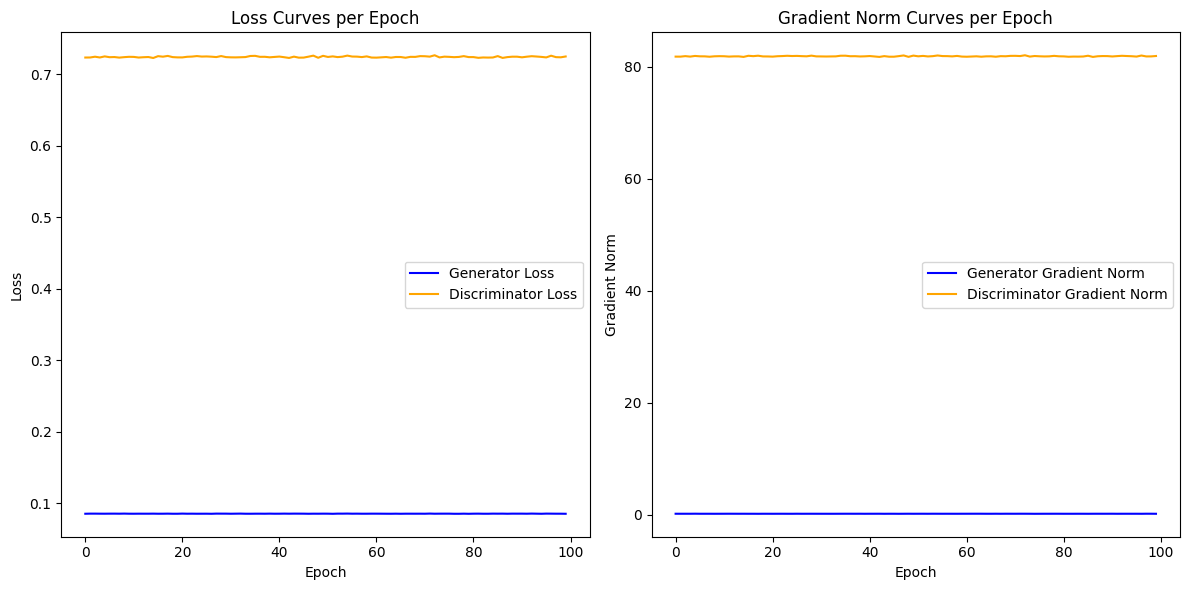

In [ ]:
import matplotlib.pyplot as plt
G_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_grad_norms])
D_grad_norms = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_grad_norms])

D_l1 = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in D_l1])
G_l1 = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in G_l1])


# Plotting Loss Curves
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(G_l1, label="Generator Loss", color="blue")
plt.plot(D_l1, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves per Epoch")
plt.legend()

# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(G_grad_norms, label="Generator Gradient Norm", color="blue")
plt.plot(D_grad_norms, label="Discriminator Gradient Norm", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Curves per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### Image generation

In [ ]:
import torch
import torchvision
import os



# Parameters
batch_size = 64  # Set your desired batch size
n_samples_target = 10000  # Total number of samples to generate

print('Model Loading...')
# Model Pipeline
mnist_dim = 784
model = Generator(g_output_dim=mnist_dim)
model = load_model(model, 'checkpoints',100)
model = torch.nn.DataParallel(model)
model.eval()

print('Model loaded.')
print('Start Generating')
os.makedirs('samples_new', exist_ok=True)

n_samples = 0
with torch.no_grad():
    while n_samples < n_samples_target:
        z = torch.randn(batch_size, 200)
        x = model(z)
        x = x.reshape(batch_size, 1, 28, 28)  # Reshape for saving
        for k in range(x.shape[0]):
            if n_samples < n_samples_target:
                torchvision.utils.save_image(x[k], os.path.join('samples_new', f'{n_samples}.png'))
                n_samples += 1

print('Generated samples done.')


Model Loading...
Model loaded.
Start Generating


<ipython-input-4-3fc1c724e5f7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))


Generated samples done.


### Calculating FID

In [ ]:
pip install pytorch-fid

In [ ]:

from torchvision.utils import save_image
path_real = 'samples_real'
os.makedirs(path_real, exist_ok=True)

# Save a subset of real images to the directory
n_samples = 10000  # Set the number of real samples you want to save
for i in range(n_samples):
    image, _ = train_dataset[i]  # Get the i-th image
    save_image(image, os.path.join(path_real, f'real_sample_{i}.png'), normalize=True)

print(f"Saved {n_samples} real MNIST images to '{path_real}'.")

from pytorch_fid import fid_score

# Calculate FID between two directories

path_fake = "samples_new"
fid_value = fid_score.calculate_fid_given_paths([path_real, path_fake], batch_size=64, device='cuda', dims=2048)

print(f"FID Score: {fid_value}")


Saved 10000 real MNIST images to 'samples_real'.


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 175MB/s]
100%|██████████| 157/157 [00:34<00:00,  4.50it/s]


FID Score: 110.99644816373157


# **Comparison Curve**

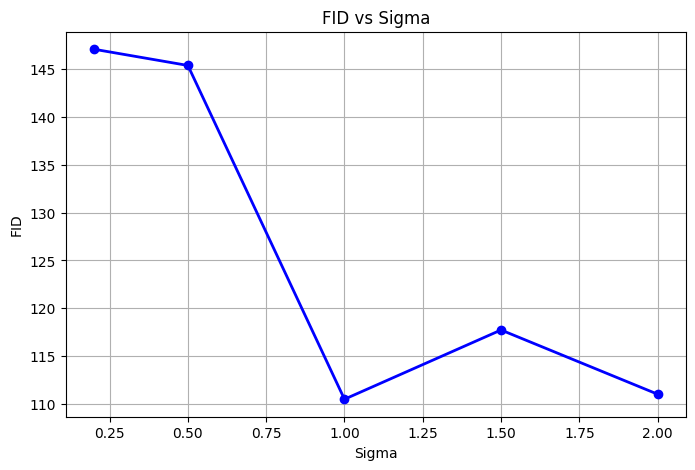

In [ ]:
import matplotlib.pyplot as plt

# Sigma values and corresponding FID scores
sigmas = [0.2, 0.5, 1, 1.5, 2]
fids = [147.10678668006395, 145.40681569759755, 110.46911600131568, 117.71712589332415, 110.99644816373157]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(sigmas, fids, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('FID vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('FID')
plt.grid(True)
plt.show()
